## Projeto Sprint 02: Modelo de Regressão para Prever o Preço de Carros

In [1]:
import copy
import warnings
import numpy as np
import pandas as pd
import seaborn as sea
import matplotlib.pyplot as plt

from scipy.stats           import probplot, shapiro, boxcox
from sklearn.preprocessing import QuantileTransformer

In [2]:
warnings.filterwarnings('ignore', category=pd.errors.SettingWithCopyWarning)

Lendo csv com o pandas

In [3]:
dataset = pd.read_csv('/content/drive/MyDrive/Dataset/cars.csv')

Gerando uma amostra aleatória de 25% do
Dataset.

In [4]:
data = dataset.sample(frac=0.25, random_state=1)

In [5]:
data.reset_index(drop=True, inplace=True)

In [6]:
data.shape

(190523, 20)

In [7]:
data.head(1)

,manufacturer,model,year,mileage,engine,transmission,drivetrain,fuel_type,mpg,exterior_color,interior_color,accidents_or_damage,one_owner,personal_use_only,seller_name,seller_rating,driver_rating,driver_reviews_num,price_drop,price
0,Land Rover,Range Rover Sport HSE Dynamic,2018,33585.0,V6,Automatic,Four-wheel Drive,Gasoline,17-23,Santorini Black,Ebony,0.0,1.0,0.0,Schaumburg Ford,4.1,4.0,45.0,500.0,53950.0


&nbsp;

# Analise exploratória

Verificando a quantidade de de valores nulos no dataset

In [8]:
total = data.shape[0]

In [9]:
nulls = data.isna().sum().sort_values(ascending=False)

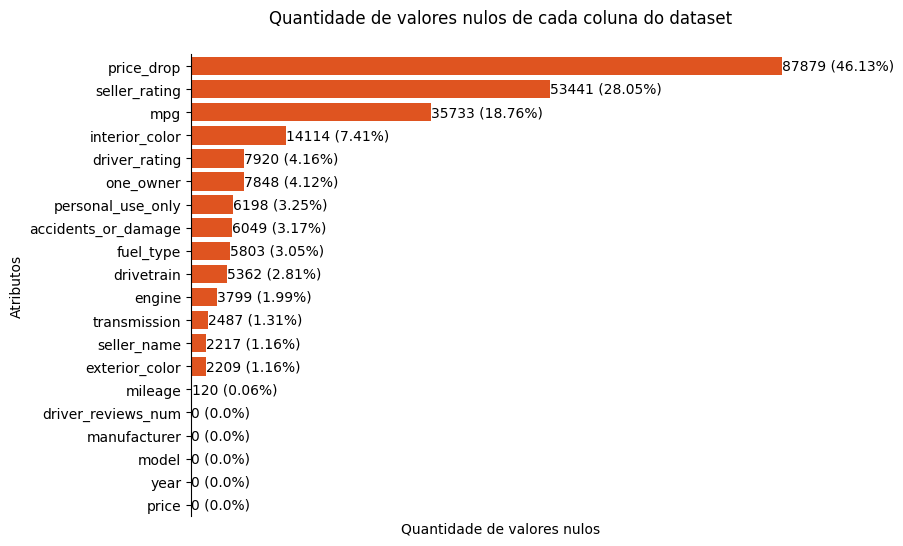

In [10]:
params = dict(
    x = nulls.values,
    y = nulls.index,
    hue = nulls.index,
    palette = ['orangered']*nulls.shape[0],
    )

plt.figure(figsize=(8, 6))
bar_nan = sea.barplot(**params)

plt.title('Quantidade de valores nulos de cada coluna do dataset', y=1.05)
plt.ylabel('Atributos')
plt.xlabel('Quantidade de valores nulos')
plt.xticks([])
plt.gca().spines[['top', 'bottom', 'right']].set_visible(False)

for p in bar_nan.patches:
    params_annotate = dict(
        xy     = ( p.get_width(), p.get_y() + p.get_height() / 2),
        xytext = (0, 0.1), textcoords= 'offset points',
        ha     = 'left',va = "center", size=10
    )
    porcentagem = round((p.get_width()/total)*100, 2)
    bar_nan.annotate("%.0f" % p.get_width()+f' ({porcentagem}%)', **params_annotate)
plt.show()

> `price_drop` há muito valores nulos junto com seller_ratting

> Os atributos com maior porcentagem de valores nulos :
* Haverá tratamento[imputar dados] ou remoção total dos valores null

Verificando a quantidade de valores unicos

In [11]:
unicos = data.nunique().sort_values(ascending=False)

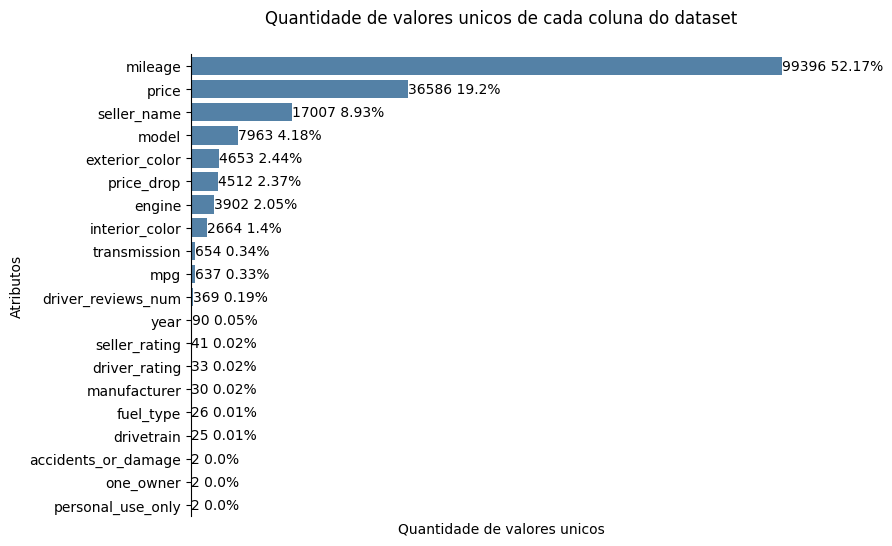

In [12]:
params = dict(
    x = unicos.values,
    y = unicos.index,
    hue = unicos.index,
    palette = ['steelblue']*unicos.shape[0],
    )

plt.figure(figsize=(8, 6))
bar_nan = sea.barplot(**params)

plt.title('Quantidade de valores unicos de cada coluna do dataset', y=1.05)
plt.ylabel('Atributos')
plt.xlabel('Quantidade de valores unicos')
plt.xticks([])
plt.gca().spines[['top', 'bottom', 'right']].set_visible(False)

for p in bar_nan.patches:
    params_annotate = dict(
        xy     = ( p.get_width(), p.get_y() + p.get_height() / 2),
        xytext = (0, 0.1), textcoords= 'offset points',
        ha     = 'left', va = "center", size=10
    )
    porcentagem = round((p.get_width()/total)*100, 2)
    bar_nan.annotate("%.0f" % p.get_width()+' '+f'{porcentagem}%', **params_annotate)
plt.show()

In [13]:
data.duplicated().sum()

548

> **Há `548` valores duplicados no conj. de dados**

## Atributo alvo(**target**) price



In [14]:
price = data['price']

In [15]:
price.describe().apply(lambda x: '{:.5f}'.format(x)).reset_index()

,index,price
0,count,190523.00000
1,mean,43085.80535
2,std,3239942.04896
3,min,319.00000
4,25%,19588.00000
5,50%,27995.00000
6,75%,39500.00000
7,max,1000000000.00000


> Target com valores muito e com um devio padrão grande

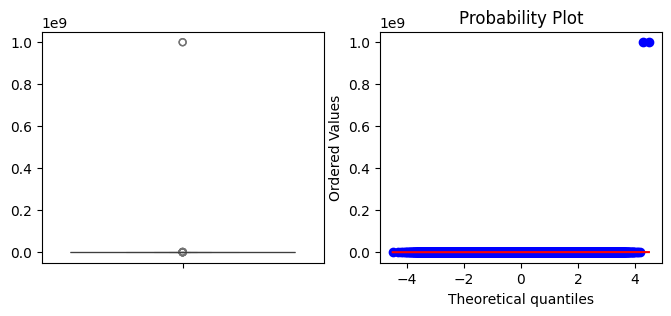

In [16]:
fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(8, 3))
sea.boxenplot(price.values, ax=ax[0])
# Plot de prob para verificar se seguem uma normal
probplot(price.values, dist='norm', plot=ax[1])
plt.show()

In [17]:
shapiro(price.values)

/usr/local/lib/python3.10/dist-packages/scipy/stats/_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


ShapiroResult(statistic=0.0004253983497619629, pvalue=0.0)

> Há outliers na target e o não seguem uma normal

Fazendo transformação do target

In [18]:
bins = int(np.sqrt(price.shape[0]))
bins

436

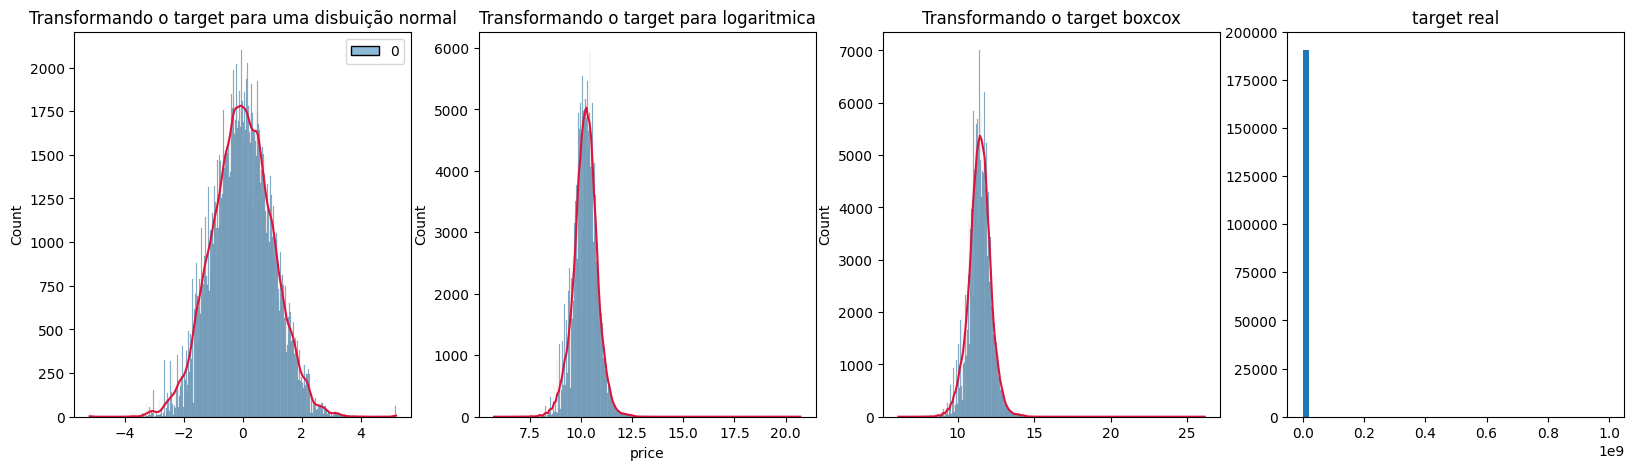

In [19]:
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(20,5))
ax[0].set_title('Transformando o target para uma disbuição normal')
norm_price = QuantileTransformer(output_distribution='normal', random_state=42)\
                        .fit_transform(price.values.reshape(-1, 1))

# Normalidade
h_1 = sea.histplot(norm_price,ax=ax[0], kde=True, bins=436)
h_1.lines[0].set_color('crimson')

# Logaritimica
ax[1].set_title('Transformando o target para logaritmica')
h_2 = sea.histplot(np.log1p(price), ax=ax[1], kde=True, bins=436)
h_2.lines[0].set_color('crimson')

# Boxcox
ax[2].set_title('Transformando o target boxcox')
h_3 = sea.histplot(boxcox(price)[0], ax=ax[2], kde=True, bins=436)
h_3.lines[0].set_color('crimson')

# Real
ax[3].set_title('target real')
ax[3].hist(price, bins=50)
plt.show()

> Os dados estão com casa decimais muito altas, com outliers:
* Poderá ser feito uma tranformação nessa `target` nos quais podem ser :
    * Transformaçao logaritmica (com o numpy)
    * QuantileTransformer(sklearn)
    * Boxcox

    > Será explicado na etapa de pré-processamentos


## Fuel_type

In [20]:
fuel_type = data['fuel_type'].value_counts().reset_index()
subset_fuel = fuel_type.iloc[0:5, :]

In [21]:
outros = np.sum(fuel_type.loc[fuel_type['count']<=350]['count'].values)

In [22]:
subset_fuel.loc[5] = ['outros', outros]

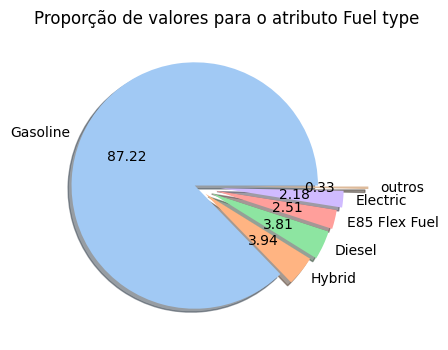

In [23]:
params = dict(
    x = subset_fuel['count'],
    labels  = subset_fuel['fuel_type'],
    autopct = '%.2f',
    explode = (0.01, 0.1, 0.14, 0.16, 0.2, 0.4),
    colors  = sea.color_palette('pastel', n_colors=6),
    shadow  = True
)
plt.figure(figsize=(5, 4))
plt.pie(**params)
plt.title('Proporção de valores para o atributo Fuel type', x=0.6)
plt.show()

## Manufaturer

In [24]:
manufacturer = data.groupby(by=['manufacturer','model'])['price']\
                   .max()\
                    .sort_values(ascending=False)[0: 10].reset_index()

In [25]:
manufacturer['modelo'] = manufacturer['manufacturer']+' '+manufacturer['model']

> Criando a coluna modelo no qual terá o marca do carro e o modelo

In [26]:
manufacturer.drop(columns=['model','manufacturer'], inplace=True)

In [27]:
manufacturer.set_index('modelo', inplace=True)

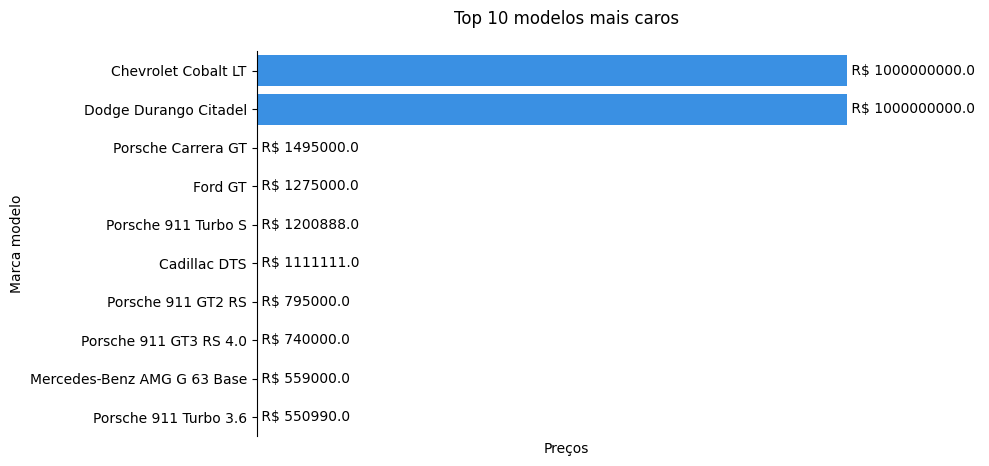

In [28]:
params = dict(
    x = manufacturer.values.reshape(1, -1)[0],
    y = manufacturer.index,
    hue = manufacturer.index ,
    palette = ['dodgerblue']*3 + ['lightsteelblue'] * 7
)
plt.figure(figsize=(8, 5))
bar_manu = sea.barplot(**params)

for p in bar_manu.patches:
    params_annotate = dict(
        xy     = ( p.get_width(), p.get_y() + p.get_height() / 2),
        xytext = (0, 0.1), textcoords= 'offset points',
        ha     = 'left', va = "center", size=10
    )
    bar_manu.annotate(" R$ %.1f" % p.get_width()+' ', **params_annotate)

plt.title('Top 10 modelos mais caros', y=1.05)
plt.ylabel('Marca modelo')
plt.xlabel('Preços')
plt.gca().spines[['top', 'bottom', 'right']].set_visible(False)
plt.xticks([])
plt.show()

Marcas com mais o na avaliação

In [29]:
manufacturer_2 = data.groupby(by=['manufacturer'])['driver_reviews_num']\
                   .sum()\
                   .sort_values(ascending=False)[0: 10]

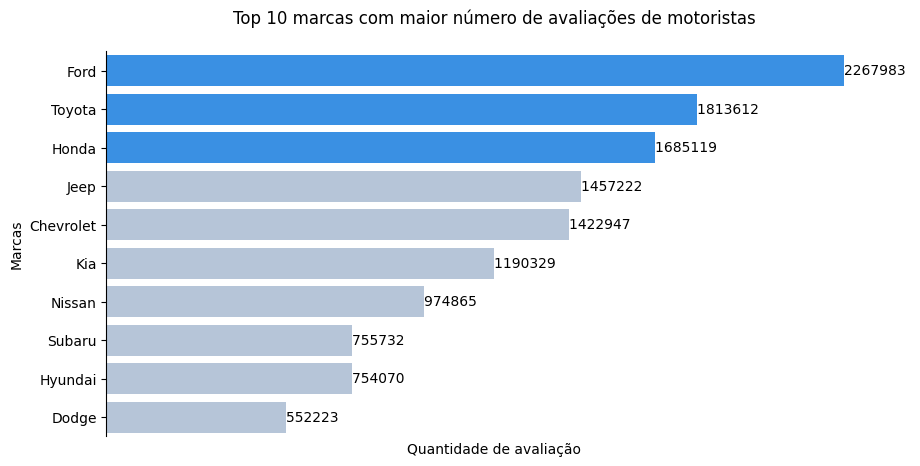

In [30]:
params = dict(
    x = manufacturer_2.values.reshape(1, -1)[0],
    y = manufacturer_2.index,
    hue = manufacturer_2.index ,
    palette = ['dodgerblue']*3 + ['lightsteelblue'] * 7
)
plt.figure(figsize=(10, 5))
bar_manu = sea.barplot(**params)

for p in bar_manu.patches:
    params_annotate = dict(
        xy     = ( p.get_width(), p.get_y() + p.get_height() / 2),
        xytext = (0, 0.1), textcoords= 'offset points',
        ha     = 'left', va = "center", size=10
    )
    bar_manu.annotate("%.0f" % p.get_width()+' ', **params_annotate)

plt.title('Top 10 marcas com maior número de avaliações de motoristas', y=1.05)
plt.ylabel('Marcas')
plt.xlabel('Quantidade de avaliação')
plt.gca().spines[['top', 'bottom', 'right']].set_visible(False)
plt.xticks([])
plt.show()

## Carros que mais tiveram redução do preço

In [31]:
manufacturer = data.groupby(by=['manufacturer','model'])['price_drop']\
                   .max()\
                    .sort_values(ascending=False)[0: 10].reset_index()

In [32]:
manufacturer['modelo'] = manufacturer['manufacturer']+' '+manufacturer['model']

# removendo coluna model e manufacturer
manufacturer.drop(columns=['model','manufacturer'], inplace=True)

In [33]:
manufacturer.set_index('modelo', inplace=True)

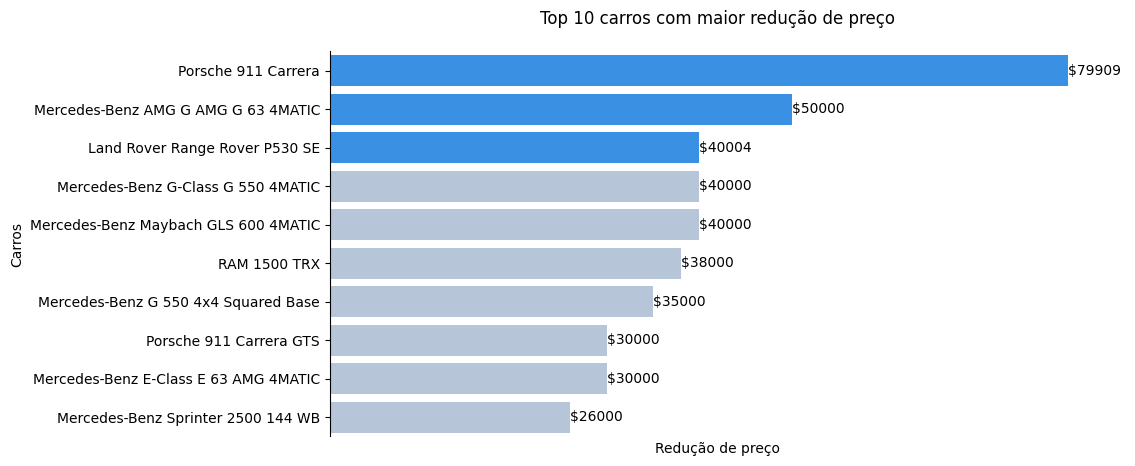

In [34]:
params = dict(
    x = manufacturer.values.reshape(1, -1)[0],
    y = manufacturer.index,
    hue = manufacturer.index ,
    palette = ['dodgerblue']*3 + ['lightsteelblue'] * 7
)
plt.figure(figsize=(10, 5))
bar_manu = sea.barplot(**params)

for p in bar_manu.patches:
    params_annotate = dict(
        xy     = ( p.get_width(), p.get_y() + p.get_height() / 2),
        xytext = (0, 0.1), textcoords= 'offset points',
        ha     = 'left', va = "center", size=10
    )
    bar_manu.annotate("$%.0f" % p.get_width()+' ', **params_annotate)

plt.title('Top 10 carros com maior redução de preço', y=1.05)
plt.ylabel('Carros')
plt.xlabel('Redução de preço')
plt.gca().spines[['top', 'bottom', 'right']].set_visible(False)
plt.xticks([])
plt.show()

## Verificando a média de notas de seller_rating e driver_rating em relação a marca dos carros

In [35]:
subset = data.groupby(
            by=['manufacturer']
        )[['seller_rating','driver_rating']].mean()\
        .sort_values(
            by=['driver_rating', 'seller_rating'], ascending=False
            )\
        .reset_index().iloc[:10, :]

In [36]:
# Dividido subset
subset_1 = subset[['manufacturer','seller_rating']]
subset_2 = subset[['manufacturer','driver_rating']]

# Renomeando colunas
subset_1.columns = ['manufacturer','mean']
subset_2.columns = ['manufacturer','mean']

# Criando o hue para ser utilizado no batplot seaborn
subset_1['hue'] = 'Seller rating'
subset_2['hue'] = 'Driver rating'

In [37]:
df = pd.concat([subset_1, subset_2])

<ipython-input-38-ee748e0d1e19>:5: UserWarning: The palette list has more values (8) than needed (2), which may not be intended.
  bar_manu = sea.barplot(**params)


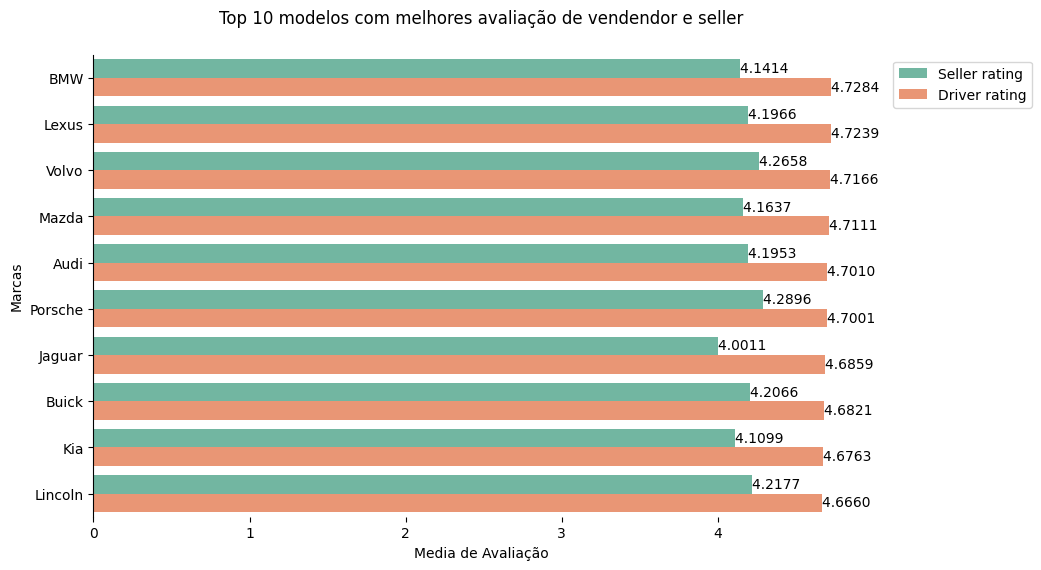

In [38]:
plt.figure(figsize=(10, 6))
params = dict(
    data=df, x='mean', y='manufacturer', hue='hue', palette=sea.color_palette('Set2')
)
bar_manu = sea.barplot(**params)

plt.gca().spines[['top', 'bottom', 'right']].set_visible(False)
for p in bar_manu.patches:
    if  p.get_width() != 0:
        params_annotate = dict(
            xy     = ( p.get_width(), p.get_y() + p.get_height() / 2),
            xytext = (0, 0.1), textcoords= 'offset points',
            ha     = 'left', va = "center", size=10
        )
        bar_manu.annotate("%.4f" % p.get_width()+' ', **params_annotate)

plt.title('Top 10 modelos com melhores avaliação de vendendor e seller', y=1.05)
plt.ylabel('Marcas')
plt.xlabel('Media de Avaliação')
plt.legend(bbox_to_anchor=(1,1,0.22,0))
plt.show()

## Analisando seller rating, driver rating e driver_num

In [39]:
subset_rdr = data[['seller_rating','driver_rating','driver_reviews_num']].dropna()

In [40]:
subset_rdr.describe()

,seller_rating,driver_rating,driver_reviews_num
count,131015.000000,131015.000000,131015.000000
mean,4.156949,4.630211,90.031050
std,0.807280,0.280682,114.267414
min,1.000000,1.000000,1.000000
25%,3.800000,4.500000,16.000000
50%,4.500000,4.700000,51.000000
75%,4.700000,4.800000,119.000000
max,5.000000,5.000000,1025.000000


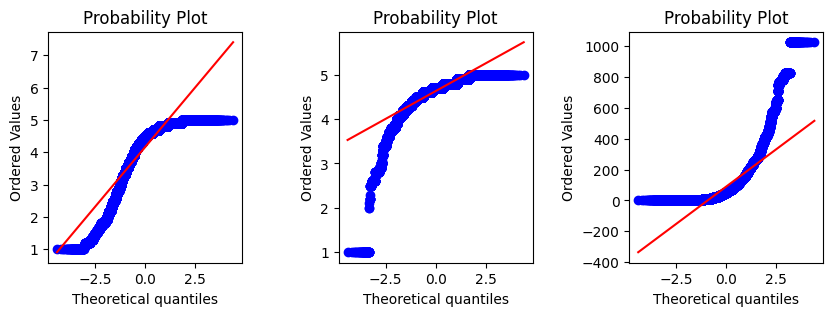

In [41]:
fig, ax = plt.subplots(nrows=1, ncols=3,figsize=(10, 3))
fig.subplots_adjust(wspace=0.5)
for column, axis in zip(subset_rdr.columns, ax.flatten()):
    probplot(subset_rdr[column], dist='norm', plot=axis)
plt.show()

> Não seguem uma normal

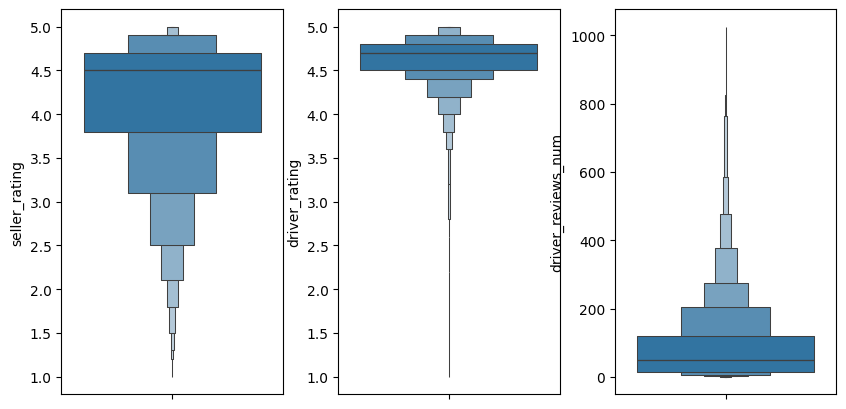

In [42]:
fig, ax = plt.subplots(nrows=1, ncols=3,figsize=(10, 5))
fig.subplots_adjust(wspace=0.25)
for column, axis in zip(subset_rdr.columns, ax.flatten()):
    sea.boxenplot(subset_rdr[column], ax=axis)
plt.show()

> Podemos ver a concentração dos dados:
>    * `Seller_rating`: os dados estão mais concentrados em 3.5-5.0, ou seja, avaliações altas.
>    * `Driver_rating`: assim como *seller_rating* os dados estão mais contrados para avaliações altas.
>    * `Driver_review_num`: os dados estão mais concetrados parar avaliações abaixo de 200.

## Seller name

In [43]:
seller = data.groupby(by=['seller_name'])['model']\
    .nunique()\
    .sort_values(ascending=False)[0:10]

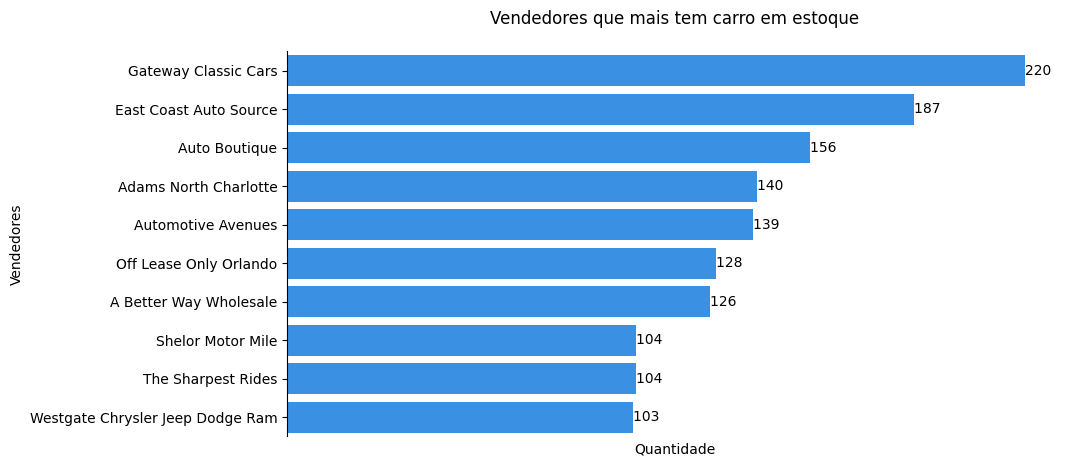

In [44]:
params = dict(
    x = seller.values.reshape(1, -1)[0],
    y = seller.index,
    hue = seller.index ,
    palette = ['dodgerblue']*10
)
plt.figure(figsize=(10, 5))
bar_manu = sea.barplot(**params)

for p in bar_manu.patches:
    params_annotate = dict(
        xy     = ( p.get_width(), p.get_y() + p.get_height() / 2),
        xytext = (0, 0.1), textcoords= 'offset points',
        ha     = 'left', va = "center", size=10
    )
    bar_manu.annotate("%.0f" % p.get_width()+' ', **params_annotate)

plt.title('Vendedores que mais tem carro em estoque', y=1.05)
plt.ylabel('Vendedores')
plt.xlabel('Quantidade')
plt.gca().spines[['top', 'bottom', 'right']].set_visible(False)
plt.xticks([])
plt.show()

## Pair_plot

In [45]:
# Selecionando so valores float
subset_pairplot = data.select_dtypes(exclude=[object, int]).dropna()

# Pegando coluna om mais de 2 valores unicos
column = subset_pairplot.nunique().loc[
   subset_pairplot.nunique() > 2
].index

In [46]:
subset_pairplot = subset_pairplot[column].sample(frac=0.25)

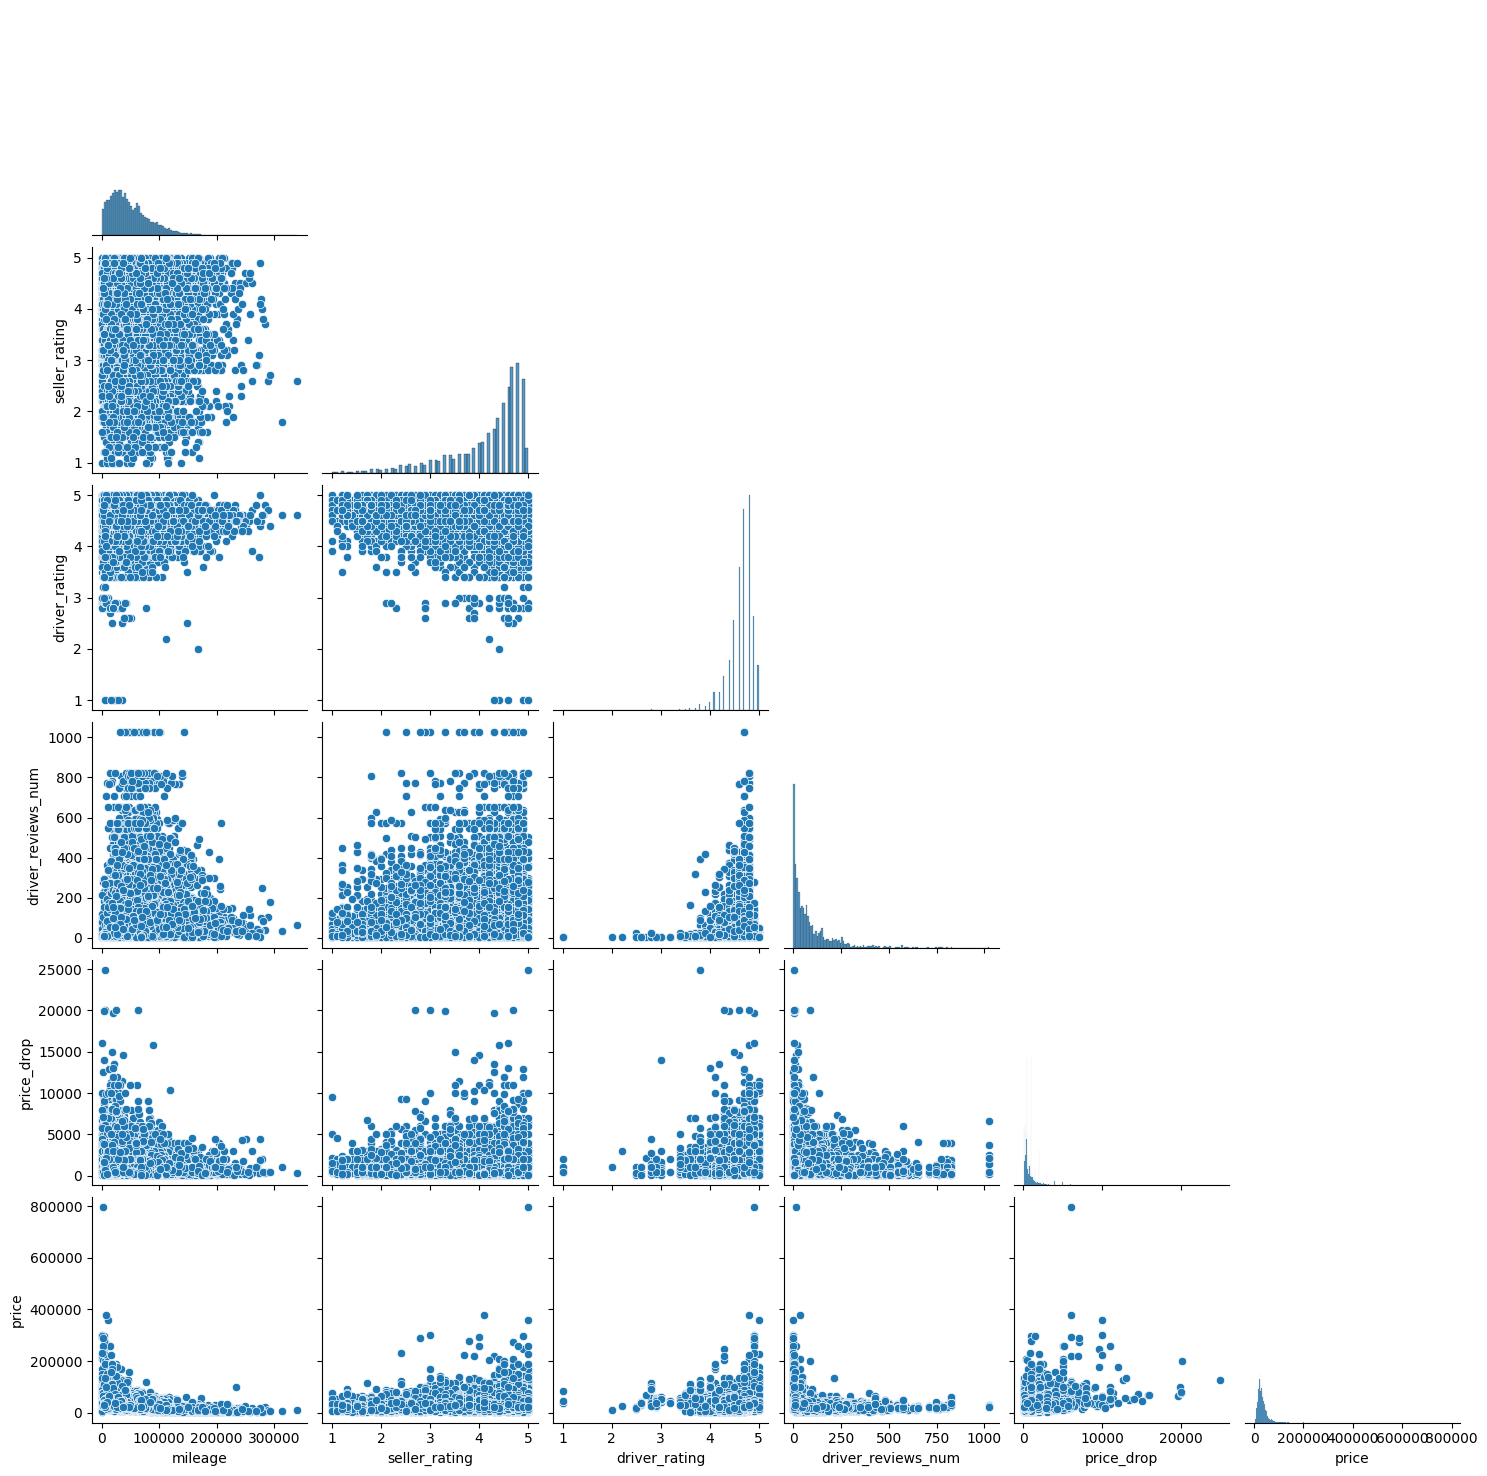

In [47]:
sea.pairplot(subset_pairplot, corner=True)

In [48]:
subset_pairplot['price'] = np.log1p(subset_pairplot['price'])

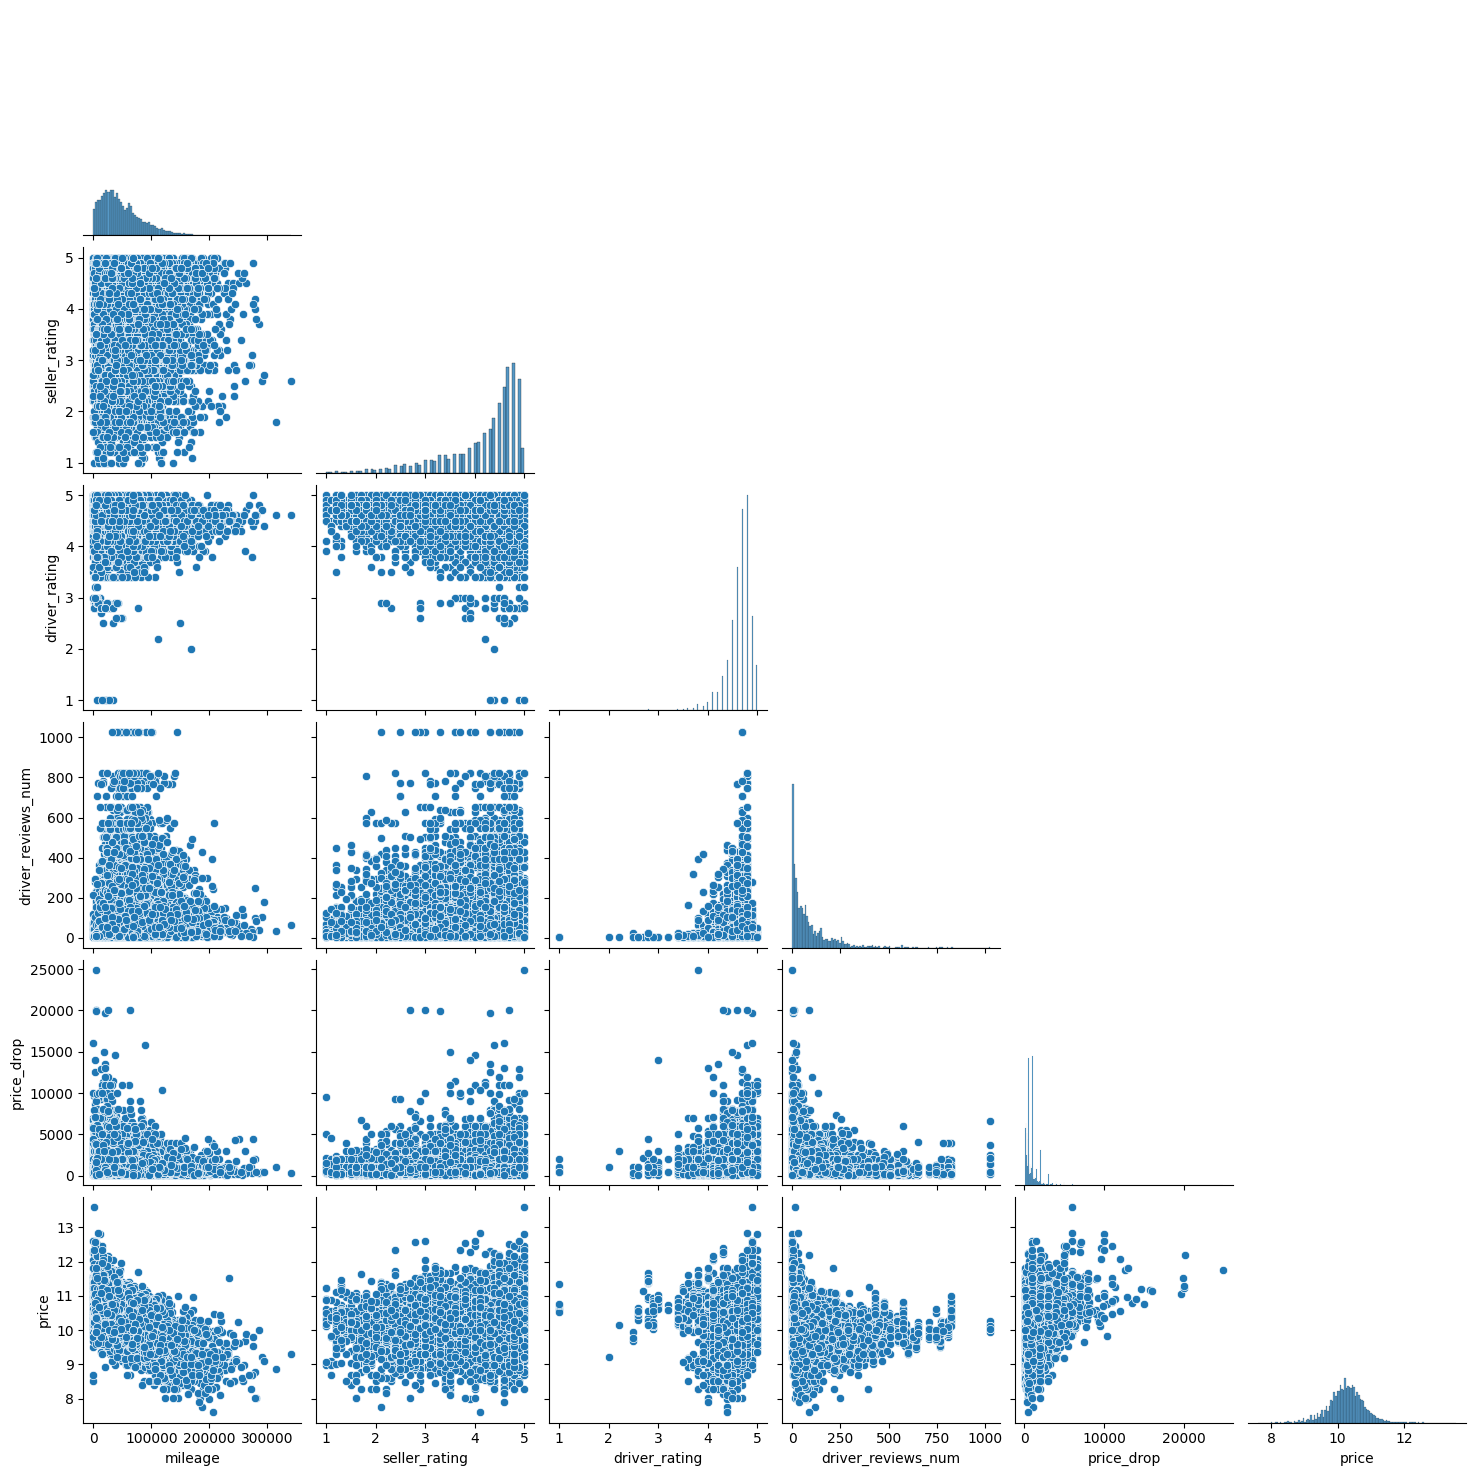

In [49]:
sea.pairplot(subset_pairplot, corner=True)

## Verificando a quantidade de valores nulos em relação ao target outlier

In [50]:
quartil_3 = np.percentile(price, 75)
quartil_2 = np.percentile(price, 25)

IQR = quartil_3 - quartil_2
sup  = quartil_3 + 1.5* IQR

In [51]:
data.loc[data['price']>= sup].shape[0]

9302

> São de 9302 instancias outliers no conj. de dados

In [52]:
nulls = data.loc[data['price']>= sup]\
            .isna()\
            .sum() \
            .sort_values(ascending=False)

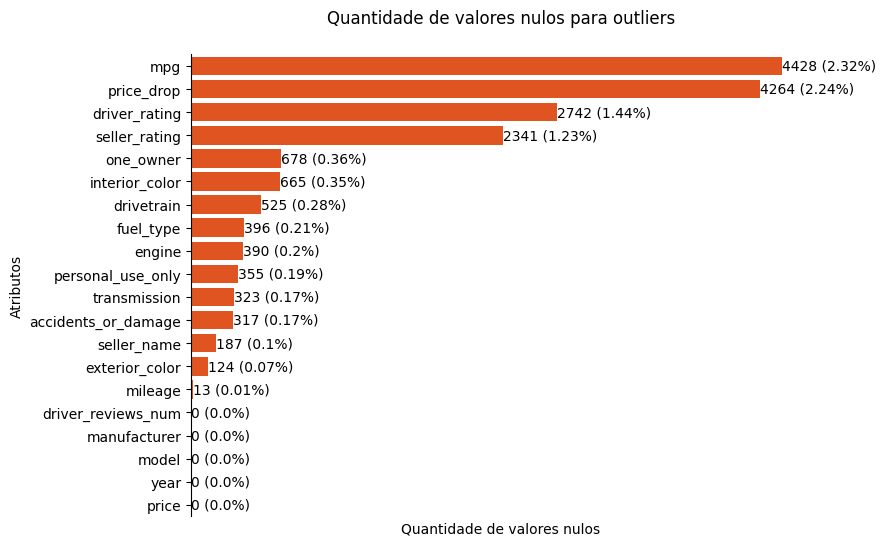

In [53]:
params = dict(
    x = nulls.values,
    y = nulls.index,
    hue = nulls.index,
    palette = ['orangered']*nulls.shape[0],
    )

plt.figure(figsize=(8, 6))
bar_nan = sea.barplot(**params)

plt.title('Quantidade de valores nulos para outliers', y=1.05)
plt.ylabel('Atributos')
plt.xlabel('Quantidade de valores nulos')
plt.xticks([])
plt.gca().spines[['top', 'bottom', 'right']].set_visible(False)

for p in bar_nan.patches:
    params_annotate = dict(
        xy     = ( p.get_width(), p.get_y() + p.get_height() / 2),
        xytext = (0, 0.1), textcoords= 'offset points',
        ha     = 'left',va = "center", size=10
    )
    porcentagem = round((p.get_width()/total)*100, 2)
    bar_nan.annotate("%.0f" % p.get_width()+f' ({porcentagem}%)', **params_annotate)
plt.show()

## **Reposta para pergunta:** Quais variáveis vocês classificam como numéricas e quais classificam como categóricas?

Categoricas

In [54]:
col_cat = data.select_dtypes(exclude=[int, float]).columns.tolist()

In [55]:
print('_'*50)
print('Variaveis Categoricas são..')
for col in col_cat:
    print(f'    - {col.title()}')
print('_'*50)

__________________________________________________
Variaveis Categoricas são..
    - Manufacturer
    - Model
    - Engine
    - Transmission
    - Drivetrain
    - Fuel_Type
    - Mpg
    - Exterior_Color
    - Interior_Color
    - Seller_Name
__________________________________________________


Para as númericas

In [56]:
col_num = data.select_dtypes(exclude=[object]).columns.tolist()

In [57]:
print('_'*50)
print('Variaveis númericas são..')
for col in col_num:
    print(f'    - {col.title()}')
print('_'*50)


__________________________________________________
Variaveis númericas são..
    - Year
    - Mileage
    - Accidents_Or_Damage
    - One_Owner
    - Personal_Use_Only
    - Seller_Rating
    - Driver_Rating
    - Driver_Reviews_Num
    - Price_Drop
    - Price
__________________________________________________


Para as variáveis numéricas, a correlação de Pearson.

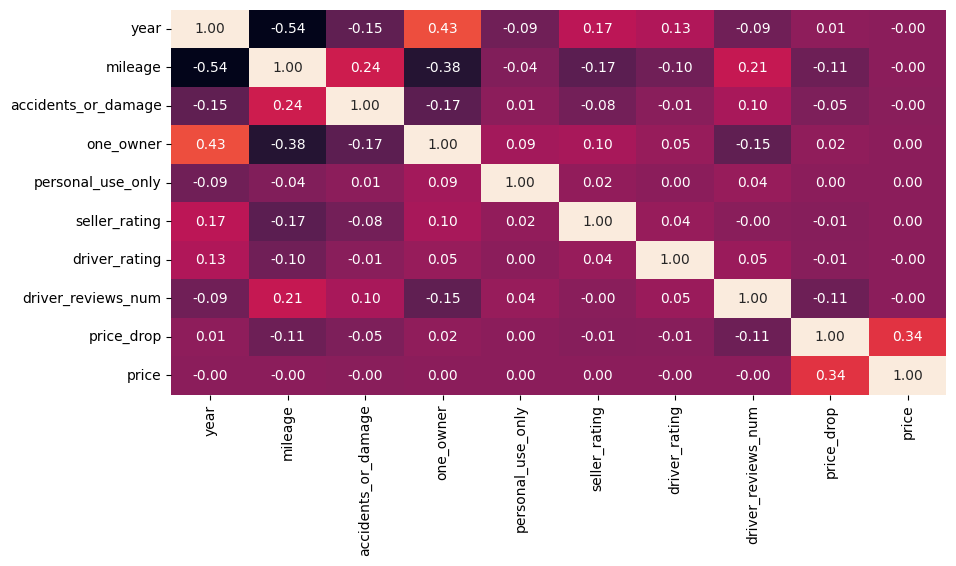

In [58]:
plt.figure(figsize=(10,5))
sea.heatmap(
    data[col_num].corr(method='pearson'), annot=True, fmt='.2f', cbar=False
)
plt.show()

> 'mileage','driver_rating', 'seller_rating'

> Muito atributos com baixa correlação com o target(`price`), serão removidos, como `mileage`, `year`,`driver

**Obs:** farei novamente correlação após o tratamento dos dados com a tranformação do target


A classe abaixo eu que criei ela verifica a correlação entre atritutos categorico-categoricos e categoricos-numericos.

In [59]:
from scipy.stats             import pointbiserialr
from scipy.stats.contingency import chi2_contingency, association
from sklearn.preprocessing   import LabelEncoder

class Correlation:
    M_ = None
    def __init__(self, column1:list, column2:list, data:pd.DataFrame):
        self.data = copy.deepcopy(data)
        self.column_names1 = column1
        self.column_names2 = column2
        self.M_ = np.zeros(shape=(len(column1) , len(column2)))

    # Cat-Cat
    def cramerV(self):
        self.data.dropna(inplace=True)

        for enum_i, i in enumerate(self.column_names1):
            for enum_j, j in enumerate(self.column_names2):

                values_i = self.data[i].values
                values_j = self.data[j].values

                if values_i.dtype=='object' or values_i.dtype==pd.Categorical:
                    values_i =  self.Encoder(values_i)
                if values_j.dtype=='object' or values_j.dtype==pd.Categorical:
                    values_j =  self.Encoder(values_j)

                subset = pd.crosstab( values_i, values_j)
                metrica = association(observed=subset, method='cramer')
                self.M_[enum_i, enum_j] = metrica

        return pd.DataFrame( data=self.M_.T, columns=self.column_names1,
                             index=self.column_names2 )
    # Categorico-Numericos
    def pointBisserl(self):
        self.data.dropna(inplace=True)


        for enum_i, i in enumerate(self.column_names1):
            for enum_j, j in enumerate(self.column_names2):

                values_i = self.data[i].values
                values_j = self.data[j].values

                if values_i.dtype=='object' or values_i.dtype==pd.Categorical:
                    values_i =  self.Encoder(values_i)
                if values_j.dtype=='object' or values_j.dtype==pd.Categorical:
                    values_j =  self.Encoder(values_j)

                corr, _ = pointbiserialr(values_i, values_j)
                self.M_[enum_i, enum_j] = corr

        return pd.DataFrame( data=self.M_.T, columns = self.column_names1,
                             index=self.column_names2 )

    def Encoder(self, X): return LabelEncoder().fit_transform(X)

In [60]:
corr = Correlation(col_cat, col_num, data).pointBisserl()

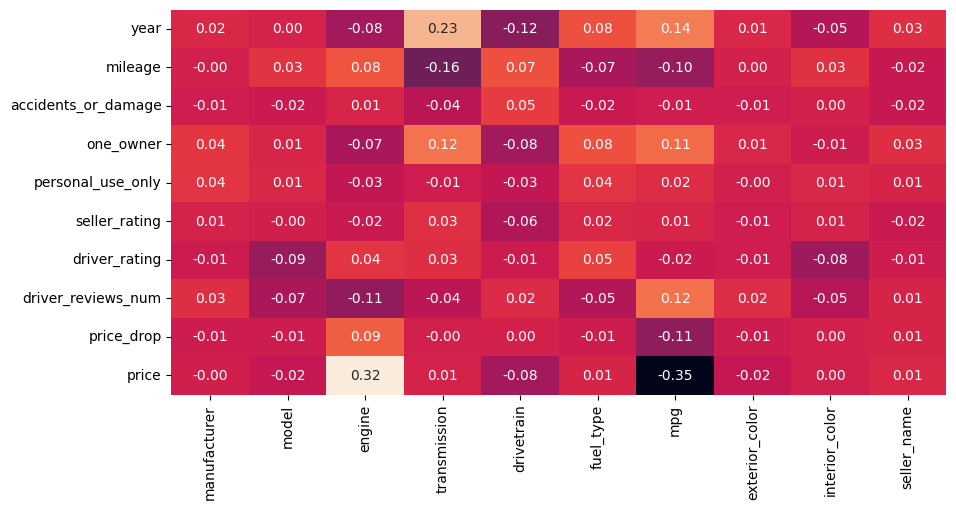

In [61]:
plt.figure(figsize=(10,5))
sea.heatmap( corr, annot=True, fmt='.2f', cbar=False)
plt.show()

> Será removido as colunas `interior_color`,todas

'manufacturer',  'transmission', 'drivertrain',
'fuel_type' ,'exterior_color', 'interior_color'

&nbsp;

&nbsp;

# Pré-processamento

Usarei pipeline para automatizar o processo de tratamento de dados e limpeza tbm

In [62]:
import copy
import numpy as np
import pandas as pd
import seaborn as sea
import warnings
import matplotlib.pyplot as plt

Ignorando os erros

In [63]:
warnings.filterwarnings('ignore', category=pd.errors.SettingWithCopyWarning)

In [64]:
# Repetindo a leitura e a amostra
dataset = pd.read_csv('/content/drive/MyDrive/Dataset/cars.csv')

In [65]:
data = dataset.sample(frac=0.25, random_state=1)

In [66]:
data.reset_index(drop=True, inplace=True)

> Fazendo o mesmo processo de leitura, para não precisar rodar todos os kernel

In [67]:
from sklearn.pipeline import Pipeline
from sklearn.base     import BaseEstimator, TransformerMixin
from sklearn.preprocessing import LabelEncoder, StandardScaler, QuantileTransformer

#### Classes de pré-processamentos

Essa classe imputa a moda ou média e uma coluna especifica

In [68]:
class Imputing(BaseEstimator,TransformerMixin):
    def __init__(self, column:str, mode:str='moda'):
        self.column = column
        self.mode   = mode

    def fit(self, X, y=None):return self

    def transform(self, X:pd.DataFrame, y=None):
        if self.mode == 'moda' : valor = X[self.column].mode()
        if self.mode == 'media': valor = X[self.column].mean()

        X[self.column] = X[self.column].fillna(valor)
        return X

A classe abaixo `AtributosEncoder` passa os valores categoricos para numericos

In [69]:
class AtributosEncoder(BaseEstimator,TransformerMixin):
    def __init__(self,columns:list|str):
        self.columns = columns

    def fit(self, X, y=None):return self

    def transform(self, X, y=None):
        for column in self.columns:
            X[column] = LabelEncoder()\
                .fit_transform(X[column].values.reshape(-1, 1))
        return X

Essa classe será utilzada paraa remover os atributos de baixa correlação

In [70]:
class RemovendoAtributos(BaseEstimator,TransformerMixin):
    def __init__(self,columns:list) -> None:
        self.columns = columns

    def fit(self, X, y=None): return self

    def transform(self, X, y=None):
        return X.drop(columns=self.columns,axis=0)

A classe remove valores nulos do conj. de dados, ou de uma coluna especifica

In [71]:
class RemovendoValoresNulos(BaseEstimator,TransformerMixin):
    def __init__(self,columns:list=None) -> None:
        self.columns = columns

    def fit(self, X, y=None):return self

    def transform(self,X,y=None):
        return X.dropna(subset=self.columns,axis=0)

A classe remove duplicados do conj. de dados, ou de uma coluna especifica

In [72]:
class DropDuplicadas(BaseEstimator,TransformerMixin):
    def __init__(self,columns:list=None) -> None:
        self.columns = columns

    def fit(self, X, y=None):return self

    def transform(self,X,y=None):
        return X.drop_duplicates(subset=self.columns)

A classe abaixo faz o dummies similar `OneHotEncoder` poderia fazer logo o dummies ao invés de passar primeiro para o Encoder, contudo, mais ha frente irei ver a correlação dos atributos pré-processados

In [73]:
class Dummies(BaseEstimator,TransformerMixin):
    def __init__(self,columns:list | str) -> None:
        self.columns = columns

    def fit(self,X,y=None):return self

    def transform(self, X:pd.DataFrame):
        return pd.get_dummies(X,columns=self.columns,dtype=int)

Essa classe padroniza os dados numericos

In [74]:
class Padronizacao(BaseEstimator,TransformerMixin):
    def __init__(self, columns:list | str) -> None:
        self.columns = columns

    def fit(self, X, y=None): return self

    def transform(self, X:pd.DataFrame, y=None):
        for column in self.columns:
            X[column] = StandardScaler()\
                .fit_transform(X[column].values.reshape(-1, 1))
        return X

#### Transformação do target

Transformando o atributo alvo para uma distribuição normal ou utilizando transformação logaritimica||boxcox, farei isso muitos algoritmos de de regressão há um ganho de performance utilizando essas transformações, além de melhor generalização.
Para a tomada dessa decisão peguei do site do sklearn, geekforgeek, além de artigos cientificos, no qual mostra um ganho de perfomance dos algorimos.

> Quando quiser descobrir o valor real faço a transformção inversa

A classe abaixo se encarrega de fazer essa transformação

In [75]:
from scipy.special import inv_boxcox

class TransformancaoTarget(BaseEstimator,TransformerMixin):
    def __init__(self, column, dtype='norm'):
        self.column = column
        self.dtype  = dtype

    def fit(self, X, y=None):return self

    def transform(self, X:pd.DataFrame, y=None):
        if self.dtype == 'log':
            X[self.column] = np.log1p(X[self.column])

        if self.dtype == 'norm':
            self.transformation = QuantileTransformer(output_distribution='normal',
                                                      random_state=42)
            X[self.column]      =  self.transformation.fit_transform(X[self.column].values.reshape(-1,1))
        if self.dtype == 'boxcox':
            X[self.column], self.lambda_cox = boxcox(X[self.column])
        return X

    def inverse(self, x):
        match (self.dtype):
            case 'log':
                return np.expm1(x)

            case 'norm':
                return self.transformation.inverse_transform(x)

            case 'boxcox':
                return inv_boxcox(x, self.lambda_cox)

&nbsp;

### Tratamento de atributos
Farei o tratamento de alguns atributos e verificar a correlação novamente com a target após a transformação.
Serão aqueles com baixa correlação ou com muitos vaolres nulos

> Também alguns teste de tratamento, para ver se há um aumento na correlação

In [76]:
col_cat = data.select_dtypes(exclude=[int, float]).columns.tolist()
col_num = data.select_dtypes(exclude=[object]).columns.tolist()

> Pegando colunas categoricas e colunas númericas

### Dados incosistente


Essa copia `trat` será feita teste no tratamento por exemplo para discretização de um certo atributo se obter uma boa correlação a classe criada para essa discretização será colocada na pipeline

In [77]:
trat = copy.deepcopy(data)

In [78]:
trat.head(1)

,manufacturer,model,year,mileage,engine,transmission,drivetrain,fuel_type,mpg,exterior_color,interior_color,accidents_or_damage,one_owner,personal_use_only,seller_name,seller_rating,driver_rating,driver_reviews_num,price_drop,price
0,Land Rover,Range Rover Sport HSE Dynamic,2018,33585.0,V6,Automatic,Four-wheel Drive,Gasoline,17-23,Santorini Black,Ebony,0.0,1.0,0.0,Schaumburg Ford,4.1,4.0,45.0,500.0,53950.0


#### Transformando o target para uma distribuição normal ou logaritmica
* Há um ganho na performance no modelo no que tange a predição em si , aumentando as metricas como r_2score e diminuindo o error
* Usando essa duas formas

In [79]:
# Transformação normal
trat['price_norm'] = TransformancaoTarget(column='price', dtype='norm')\
                                .fit_transform(trat)['price']

In [80]:
# transformação logaritmica
trat['price_log' ] = TransformancaoTarget(column='price', dtype='log')\
                                .fit_transform(trat)['price']

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


#### Price drop
Possue muito valores nulos, essa coluna informa de quanto foi a redução do preço do carro. Com valores nulos podemos supor que esses `NAN` informa que não houve redução do preço do carro com isso o tratamento consiste substituir o NAN por zero

In [81]:
class ImputZero(BaseEstimator,TransformerMixin):
    def __init__(self):pass
    def fit(self, X, y=None):return self
    def transform(self, X, y=None):
        X['price_drop'] = X['price_drop'].fillna(0)
        return X

In [82]:
trat = ImputZero().fit_transform(trat)

In [83]:
trat[['price','price_log','price_norm']].corrwith(trat['price_drop'])

price         0.121568
price_log     0.121568
price_norm    0.183553
dtype: float64

> Há uma redução no valor da correlação, contudo, será testado no treinamento \
Obs: Isso foi feito após o treinamento

#### Dados incosistentes  para drivetrain

In [84]:
trat['drivetrain'].str.title().value_counts()

drivetrain
Front-Wheel Drive                                              60248
All-Wheel Drive                                                57740
Four-Wheel Drive                                               39360
Rear-Wheel Drive                                               24332
Fwd                                                             1563
Awd                                                              910
4Wd                                                              480
Rwd                                                              446
Unknown                                                           27
Four-Wheel Drive With Locking And Limited-Slip Differential       13
Front-Wheel Drive With Limited-Slip Differential                  11
All-Wheel Drive With Locking And Limited-Slip Differential         7
Front Wheel Drive                                                  6
Four Wheel Drive                                                   4
All-Wheel Drive With Lo

> Nesse atributo possue muitos valores que são a mesma coisa mas escrito de forma diferente como:

* FWD, 4x2=Front-Wheel Drive
* AWD=All Wheel Drive
* 4WD, 4x4=Four-Wheel Drive
* RWD=Rear Wheel Drive
> > Outros valores como por exemplo All-Wheel Drive With Locking Differential será transformado para All-Wheel Drive e assim por diante  

In [85]:
class TratandoInconsistenciaDrivetrain(BaseEstimator,TransformerMixin):
    def __init__(self):pass

    def fit(self, X, y=None):return self

    def transform(self, X, y=None):
        # Front-Wheel Drive
        X['drivetrain'] = np.where(
            X['drivetrain']=='FWD', 'Front-Wheel Drive', X['drivetrain']
        )
        X['drivetrain'] = np.where(
            X['drivetrain'].str.contains('Front'), 'Front-Wheel Drive', X['drivetrain']
        )
        X['drivetrain'] = np.where(
            X['drivetrain']=='4x2', 'Front-Wheel Drive', X['drivetrain']
        )

        # Four-Wheel Drive
        X['drivetrain'] = np.where(
            X['drivetrain']=='4WD', 'Four-Wheel Drive', X['drivetrain']
        )
        X['drivetrain'] = np.where(
            X['drivetrain'].str.contains('Four'), 'Four-Wheel Drive', X['drivetrain']
        )
        X['drivetrain'] = np.where(
            X['drivetrain']=='4x4', 'Four-Wheel Drive', X['drivetrain']
        )

        # All-Wheel Drive
        X['drivetrain'] = np.where(
            X['drivetrain']=='AWD', 'All-Wheel Drive', X['drivetrain']
        )
        X['drivetrain'] = np.where(
            X['drivetrain'].str.contains('All'), 'All-Wheel Drive', X['drivetrain']
        )

        # Rear-Wheel Drive
        X['drivetrain'] = np.where(
            X['drivetrain']=='RWD', 'Rear-Wheel Drive', X['drivetrain']
        )
        X['drivetrain'] = np.where(
            X['drivetrain'].str.contains('Rear'), 'Rear-Wheel Drive', X['drivetrain']
        )
        X['drivetrain'] = np.where(
            X['drivetrain'] == 'Unknown', pd.NA, X['drivetrain']
        )
        X['drivetrain'] = X['drivetrain'].str.replace('-',' ').str.title()
        return X

In [86]:
trat = TratandoInconsistenciaDrivetrain()\
                .fit_transform(trat)

In [87]:
trat['drivetrain'].str.title().value_counts()

drivetrain
Front Wheel Drive    67191
All Wheel Drive      58663
Four Wheel Drive     39861
Rear Wheel Drive     24781
Name: count, dtype: int64

#### Imputing MPG e incosistencia

In [88]:
trat['mpg'].unique()

array(['17-23', '14-19', '13-17', '21-31', nan, '21-26', '15-21', '21-29',
       '18-25', '28-34', '26-36', '29-39', '20-28', '19-30', '17-25',
       '22-26', '20-32', '19-27', '19-28', '53-46', '16-25', '21-27',
       '26-31', '19-26', '49-47', '21-28', '19-25', '22-31', '28-39',
       '19-24', '23-32', '25-32', '20-25', '29-35', '26-33', '14-23',
       '17-21', '30-38', '24-28', '25-36', '16-23', '19-23', '27-32',
       '24-33', '24-30', '25-35', '16-18', '16-21', '18-22', '43-41',
       '30-40', '17-22', '20-29', '27-35', '20-23', '17-20', '23-29',
       '14-20', '24-31', '22-28', '18-23', '14-22', '26-38', '31-40',
       '15-20', '20-27', '16-19', '33-40', '36-36', '15-24', '48-48',
       '22-29', '21-30', '28-37', '20-26', '14-21', '23-34', '26-30',
       '0-0', '27-36', '16-22', '29', '20-31', '17-28', '55-54', '35-41',
       '22-27', '25-30', '24-32', '27-31', '27-33', '25-28', '18-24',
       '24-29', '23-30', '31-36', '15-19', '13-18', '25-29', '18-27',
       '17-

Para valores `0-0` será imputado a moda com relação ao tipo de combustivel

In [89]:
trat.loc[trat['mpg']=='0-0'][['mpg','fuel_type']].value_counts()

mpg  fuel_type                    
0-0  Gasoline                         705
     Diesel                           639
     Hybrid                            44
     E85 Flex Fuel                     36
     Unspecified                        5
     Biodiesel                          1
     Compressed Natural Gas             1
     Gaseous                            1
     Gasoline Fuel                      1
     Gasoline/Mild Electric Hybrid      1
Name: count, dtype: int64

In [90]:
class ImputingGasoMpg(BaseEstimator, TransformerMixin):
    def __init__(self):pass
    def fit(self, X, y=None):return self
    def transform(self, X_, y=None):
        X = copy.deepcopy(X_)
        zeros_zeros = X.loc[X['mpg']=='0-0'][['mpg','fuel_type']]\
                       .value_counts().reset_index()

        for i in zeros_zeros['fuel_type']:
            fuel = X.loc[(X['fuel_type']==i) & (X['mpg']!='0-0')]['mpg'].dropna()
            if len(fuel.mode()) == 1:
                X['mpg'] = np.where(
                    (X['mpg'] == '0-0') & (X['fuel_type']==i), fuel.mode(), X['mpg']
                )
        return X

In [91]:
trat = ImputingGasoMpg().fit_transform(trat)

> Milhas por galão indica a quantidade de milhas que um veículo pode percorrer com um galão de combustível e os valores devem estar na ordem correta sendo minimo-maximo. Contudo a dados incosistentes com a ordem de  maximo-minimo ou com so minimo, serão tratados e imputados:
- 20-12 : será transformado para 12-20
- 121-121: será transformado para 121-nan
- 0-12: será transformado para nan-12
- 12-2: 2-12

> Valores nan serão removidos no conj. de dados

In [92]:
class TratandoIncositencia(BaseEstimator,TransformerMixin):
    # Essa função ordena para mpg_min-mpg_max
    def fit(self, X, y=None):return self
    def ordenando_min_max(self, a, b):
        minimo = []
        maximo = []

        for i, j in zip(a, b):

            if any([pd.isna(i) , pd.isna(j)]):
                valor_a , valor_b = i, j

                if not(pd.isna(i)): valor_a = round(float(i),1)
                if not(pd.isna(j)): valor_b = round(float(j),1)

                minimo.append(valor_a)
                maximo.append(valor_b)

            elif i > j and j!= 0 and (str(i) != 'nan' and str(j) != 'nan'):
                minimo.append(round(float(j),1))
                maximo.append(round(float(i),1))
            else:
                minimo.append(round(float(i),1))
                maximo.append(round(float(j),1))

        return minimo,maximo

    # Dividi o mpg (valor-valor)
    def transform(self, X, y=None):
        matriz = X['mpg'].str.split('-').values
        maximo = []
        minimo = []
        for lista in matriz:
            valores = np.array(lista).astype(float).tolist()
            if type(valores) == list:
                if len(valores) == 2:
                    valor_min, valor_max = valores[0], valores[1]

                    if valor_min==0 and valor_max==0:
                        minimo.append(0)
                        maximo.append(0)
                    else:
                        valor_max = 0.0 if valor_min==valor_max else valor_max

                        minimo\
                            .append( float(valor_min) if valor_min!=0.0 else pd.NA )
                        maximo\
                            .append( float(valor_max) if valor_max!=0.0 else pd.NA )
                else:
                    valor_min = valores[0]
                    minimo\
                        .append( float(valor_min) if valor_min!=0.0 else pd.NA  )
                    maximo.append(pd.NA)
            else:
                minimo.append(pd.NA)
                maximo.append(pd.NA)
        X['mpg_minimo'], X['mpg_maximo'] = self.ordenando_min_max(minimo, maximo)
        return X

In [93]:
def refazendo_mpg(minimo, maximo):
    return np.array([ str(i)+'-'+str(j) for i, j in zip(minimo, maximo) ])

In [94]:
trat = TratandoIncositencia().fit_transform(trat)

In [95]:
a = trat[['mpg_minimo','mpg_maximo']].dropna().values
a

array([[17.0, 23.0],
       [14.0, 19.0],
       [13.0, 17.0],
       ...,
       [17.0, 22.0],
       [15.0, 22.0],
       [18.0, 24.0]], dtype=object)

Irei verificar se ha uma correlação linera entre as duas variaveis

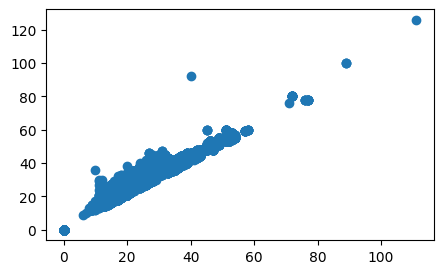

In [96]:
plt.figure(figsize=(5,3))
plt.scatter(a[:,0], a[:,1])
plt.show()

> Podemos ver uma relação linear com o mpg_min e mpg_max \
> Para imputar os valores nulos irei fazer a predição deles

In [97]:
a = trat[['mpg_minimo','mpg_maximo']].values
np.unique(refazendo_mpg(a[:,0], a[:,1]))

array(['0.0-0.0', '10.0-12.0', '10.0-13.0', '10.0-14.0', '10.0-15.0',
       '10.0-16.0', '10.0-17.0', '10.0-36.0', '10.0-<NA>', '102.0-<NA>',
       '11.0-13.0', '11.0-14.0', '11.0-15.0', '11.0-16.0', '11.0-17.0',
       '11.0-18.0', '11.0-19.0', '11.0-20.0', '11.0-21.0', '11.0-24.0',
       '11.0-27.0', '11.0-29.0', '11.0-30.0', '11.0-<NA>', '111.0-126.0',
       '12.0-14.0', '12.0-15.0', '12.0-16.0', '12.0-17.0', '12.0-18.0',
       '12.0-19.0', '12.0-20.0', '12.0-21.0', '12.0-23.0', '12.0-24.0',
       '12.0-30.0', '12.0-<NA>', '121.0-<NA>', '13.0-14.0', '13.0-15.0',
       '13.0-16.0', '13.0-17.0', '13.0-18.0', '13.0-18.5', '13.0-19.0',
       '13.0-20.0', '13.0-21.0', '13.0-22.0', '13.0-23.0', '13.0-25.0',
       '13.0-26.0', '13.0-<NA>', '14.0-15.0', '14.0-16.0', '14.0-17.0',
       '14.0-18.0', '14.0-19.0', '14.0-20.0', '14.0-21.0', '14.0-22.0',
       '14.0-23.0', '14.0-24.0', '14.0-25.0', '14.0-26.0', '14.0-<NA>',
       '15.0-16.0', '15.0-17.0', '15.0-18.0', '15.0-19.0', '15

> Podemos ver que os dados estão na ordem padrão

Fazendo predict imputing para essas colinas

In [98]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute       import IterativeImputer
from sklearn.ensemble     import RandomForestRegressor

class ImputingMpg(BaseEstimator,TransformerMixin):
    m_, n_ = None, None
    def fit(self, X, y=None):return self
    def transform(self, X, y=None):
        valores = X[['mpg_minimo','mpg_maximo']].values
        minimo, maximo = valores[:,0], valores[:, 1]

        #Pegando o indicess que contem valores nan-nan
        # que serão ignorado na faze de imputing
        self.index = self.index_nan(minimo, maximo)

        minimo, maximo = self.imputing_max_min(minimo, maximo, self.index)
        self.m_, self.n_ = minimo, maximo
        mpg = self.refazendo_mpg(minimo, maximo)
        # Colocado o nan nos seus repectivos indices
        for i in self.index:
            mpg.insert(i, pd.NA)

        X['mpg'] = mpg
        X.drop(columns=['mpg_minimo','mpg_maximo'], inplace=True)
        return X



    # Essa função pega os indices de valores que são nan-nan
    # para que não seja imputados e sim removidos dps do dataset
    def index_nan(self ,minimo, maximo):
        idx = []
        for enum, (i, j) in enumerate(zip(minimo, maximo)):
            if pd.isna(i) and pd.isna(j):
                idx.append(enum)
        return idx

    # Essa função faz o predict imputing
    def imputing_max_min(self, minimo, maximo, index):
        # Minimo mpg
        minimo = pd.Series(
            np.delete(minimo, index)).replace({pd.NA: np.nan})

        # Maximo mpg
        maximo = pd.Series(
            np.delete(maximo, index)).replace({pd.NA: np.nan})


        mpg = np.c_[minimo, maximo]

        imputing = IterativeImputer(
            estimator=RandomForestRegressor(random_state=1),
            max_value=121,
            random_state=42,
        )

        imputed = np.around(imputing.fit_transform(mpg), 1)

        return imputed[:,0], imputed[:, 1]

    # Refaz o formando de valor do mpg
    def refazendo_mpg(self, minimo, maximo):
        return [ str(i)+'-'+str(j) for i, j in zip(minimo, maximo) ]

In [99]:
imput = ImputingMpg()
trat = imput.fit_transform(trat)

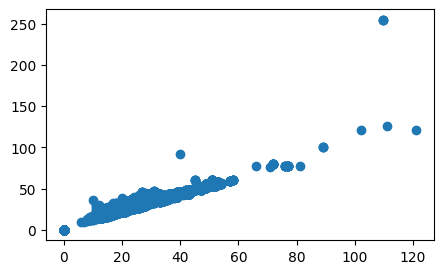

In [100]:
plt.figure(figsize=(5,3))
plt.scatter(imput.m_, imput.n_)
plt.show()

In [101]:
trat['mpg'].unique()

array(['17.0-23.0', '14.0-19.0', '13.0-17.0', '21.0-31.0', <NA>,
       '21.0-26.0', '15.0-21.0', '21.0-29.0', '18.0-25.0', '28.0-34.0',
       '26.0-36.0', '29.0-39.0', '20.0-28.0', '19.0-30.0', '17.0-25.0',
       '22.0-26.0', '20.0-32.0', '19.0-27.0', '19.0-28.0', '46.0-53.0',
       '16.0-25.0', '21.0-27.0', '26.0-31.0', '19.0-26.0', '47.0-49.0',
       '21.0-28.0', '19.0-25.0', '22.0-31.0', '28.0-39.0', '19.0-24.0',
       '23.0-32.0', '25.0-32.0', '20.0-25.0', '29.0-35.0', '26.0-33.0',
       '14.0-23.0', '17.0-21.0', '30.0-38.0', '24.0-28.0', '25.0-36.0',
       '16.0-23.0', '19.0-23.0', '27.0-32.0', '24.0-33.0', '24.0-30.0',
       '25.0-35.0', '16.0-18.0', '16.0-21.0', '18.0-22.0', '41.0-43.0',
       '30.0-40.0', '17.0-22.0', '20.0-29.0', '27.0-35.0', '20.0-23.0',
       '17.0-20.0', '23.0-29.0', '14.0-20.0', '24.0-31.0', '22.0-28.0',
       '18.0-23.0', '14.0-22.0', '26.0-38.0', '31.0-40.0', '15.0-20.0',
       '20.0-27.0', '16.0-19.0', '33.0-40.0', '36.0-40.4', '15.0-24.0',

In [102]:
corr = Correlation(['mpg'] ,['price', 'price_log','price_norm'], trat).pointBisserl()

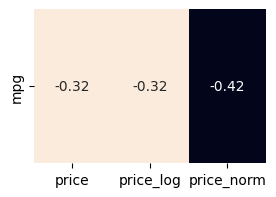

In [103]:
plt.figure(figsize=(3,2))
sea.heatmap(corr.T, annot=True, fmt='.2g', cbar=False)
plt.show()

In [104]:
trat.dropna(subset=['mpg','engine'], inplace=True)

In [105]:
class MpgMaxMin(BaseEstimator, TransformerMixin):
    def __init__(self):       pass
    def fit(self, X, y=None): return self

    def transform(self, X, y=None):
        mpg_max = []
        mpg_min = []
        mpg_separado = X['mpg'].str.split('-').values

        for lista in mpg_separado:
            if lista == pd.NA:
                mpg_min.append(pd.NA)
                mpg_max.append(pd.NA)
            else:
                mpg_min.append(int(float(lista[0])))
                mpg_max.append(int(float(lista[1])))

        X['mpg_minimo'] = np.array(mpg_min)
        X['mpg_maximo'] = np.array(mpg_max)
        return X

In [106]:
trat = MpgMaxMin().fit_transform(trat)

In [107]:
corr = Correlation(['mpg_minimo', 'mpg_maximo'] ,
                 ['price', 'price_log','price_norm'],
                   trat).pointBisserl()

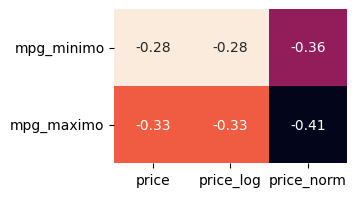

In [108]:
plt.figure(figsize=(3,2))
sea.heatmap(corr.T, annot=True, fmt='.2g', cbar=False)
plt.show()

> Mpg será excluido e ficarão as colunas mpg_minimo e mpg_maximo

#### Antes de usar a as classes de pré-processamento quero fazer algumas transformações , como discretização, e verificar se há um ganho de correlação.
> Discretização e passar valores numerico para categoricos ordinais

#### discretização dos `seller_rating` e `driver_rating`
* Notas 1 - 3: Avaliações péssimas
* Notas 3 - 4: Avaliações neutras
* Notas 4 - 5: Avaliações possitivas  

In [109]:
trat[['seller_rating','driver_rating']].describe()

,seller_rating,driver_rating
count,112247.000000,151830.000000
mean,4.159029,4.640731
std,0.805314,0.239676
min,1.000000,1.000000
25%,3.800000,4.500000
50%,4.500000,4.700000
75%,4.700000,4.800000
max,5.000000,5.000000


In [110]:
label = ['Muito Baixo', 'Baixo', 'Médio', 'Alto', 'Muito Alto']
bins  = [0, 1, 2, 3, 4, 5]

Para o seller_rating

In [111]:
seller = trat['seller_rating'].values

In [112]:
seller = pd.cut(x=seller, bins=bins , labels=label)
seller

['Muito Alto', 'Médio', 'Muito Alto', 'Muito Alto', 'Médio', ..., 'Muito Alto', 'Muito Alto', 'Alto', 'Muito Alto', 'Muito Alto']
Length: 154585
Categories (5, object): ['Muito Baixo' < 'Baixo' < 'Médio' < 'Alto' < 'Muito Alto']

In [113]:
trat['seller_rating_cat'] = seller.astype(object)

Para driving_rating

In [114]:
driver = trat['driver_rating'].values

In [115]:
driver = pd.cut(x=driver, bins=bins , labels=label)
driver

['Alto', 'Muito Alto', 'Muito Alto', 'Muito Alto', 'Muito Alto', ..., 'Muito Alto', 'Muito Alto', 'Muito Alto', 'Muito Alto', 'Muito Alto']
Length: 154585
Categories (5, object): ['Muito Baixo' < 'Baixo' < 'Médio' < 'Alto' < 'Muito Alto']

In [116]:
trat['driver_rating_cat'] = driver.astype(object)

Vendo correlação desse novos atributos

In [117]:
cat  = ['seller_rating_cat', 'driver_rating_cat']
corr = Correlation(cat, ['price','price_log','price_norm'], trat).pointBisserl()

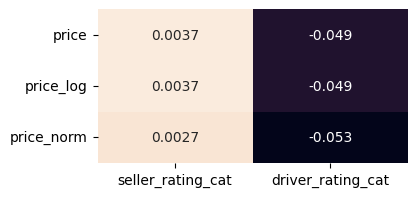

In [118]:
plt.figure(figsize=(4,2))
sea.heatmap(corr, annot=True, fmt='.2g', cbar=False)
plt.show()

> Não haverá classe de pré-processamento para discretização, pois a correlação com o target é muito baixa

#### Para o atributo `engine` irei dividir e com isso criar novas colunas com a `valculas`(V..),  `cilindro`(V..), litros(..L)  e informações adicionais e ver a correlação dos dados
> Essa coluna possui a descrição do veiculo então há muitas informações nela contida. Com a divisão posso ganhar mais informação para a tarefa de regressão multipla, assim, aumentando as métricas como o R2_score e diminuindo o error

Essa classes pega a coluna `engine` que contituita de diversas caracteristica que o veículo possue e separa em 4 novas colunas que serão as :
* **Cilindros** : V8, I4, H4, 4-CYLINDER, CLY, VR6....
* **Valvulas**: 16v, {}V....
* **Litros**:3.5L, 4.5L
* **engine_add**: informações adcionais


In [119]:
trat['engine'].unique()

array(['V6', '5.6L V8 32V GDI DOHC',
       'I-FORCE 5.7L V-8 DOHC, VVT-i variable valve control, engine with',
       ..., '318 ci V8', '5L V-12 DOHC, engine with 296HP',
       '3.6L H-6 engine with 282HP'], dtype=object)

In [120]:
import re
class CriandoNovasColunas(BaseEstimator, TransformerMixin):
    def __init__(self):       pass
    def fit(self, X, y=None): return self

    def condicao(self, palavra):
        return len(palavra) >= 1 and len(palavra)<=3 and any([c.isnumeric() for c in palavra])

    def removendo_espaco(self, text):
        if str(text) == 'nan': return np.NAN
        string = r'(\d+)\s*L'
        litros = re.sub(string, r'\1L ', text)

        return litros


    def transform(self, X, y=None):
        X_new = copy.deepcopy(X['engine'])
        X_new = X_new.apply(self. removendo_espaco)
        lista = X_new.str.upper()\
                     .str.replace('VALVE','V')\
                     .str.replace('-','')\
                     .str.replace(':',' ')\
                     .str.replace(',',' ')\
                     .str.replace('/',' ')\
                     .str.split(' ')


        cilindros = []
        valvulas  = []
        litros    = []

        for lista_palavra in lista:
            is_add = False

            if str(lista_palavra) == 'nan':
                cilindros.append(pd.NA)
                is_add = True
            else:
                for enum, palavra in enumerate(lista_palavra):

                    if  len(palavra) == 0: pass
                    elif palavra[0] in ['V','I','H','W'] and not(is_add) and self.condicao(palavra):
                        cilindros.append(
                            palavra.replace('W','V')\
                                   .replace('H','V')\
                                   .replace('R','')\
                            )
                        is_add = True
                        break

                    elif 'CYL' in palavra and not(is_add):
                        palavra  = 'V'+palavra\
                                      .replace('CYLINDER','')\
                                      .replace('CYL','')\
                                      .replace('R','')\

                        char_ant = lista_palavra[enum-1]
                        booleano = char_ant.isnumeric()

                        if len(palavra) == 1 and booleano:
                            cilindros.append(palavra+char_ant)
                            is_add = True
                            break

                if not(is_add):cilindros.append(pd.NA)

        for lista_palavra in lista:
            is_add = False

            if str(lista_palavra) == 'nan':
                valvulas.append(pd.NA)
                is_add = True
            else:
                for enum, palavra in enumerate(lista_palavra):

                    if len(palavra) == 0:pass

                    elif  palavra[-1] == 'V' and not(is_add) and self.condicao(palavra):
                        valvulas.append(palavra)
                        is_add = True

                if not(is_add): valvulas.append(pd.NA)

        for lista_palavra in lista:
            is_add = False
            if str(lista_palavra) == 'nan':
                litros.append(pd.NA)
                is_add = True
            else:
                for enum, palavra in enumerate(lista_palavra):
                    tamanho = len(palavra)
                    if len(palavra)==0: pass
                    elif palavra[-1] == 'L' and tamanho >1 and not('Y' in palavra or 'B' in palavra) and tamanho <= 4 and any([c.isnumeric() for c in palavra]):
                        litros.append(
                            pd.NA if 370.0 == float(palavra[:-1]) else float(palavra[:-1])
                            )
                        is_add = True
                        break
                if not(is_add): litros.append(pd.NA)

        X['cilindros'] = np.array(cilindros)
        X['valvulas']  = np.array(valvulas)
        X['litros']    = np.array(litros)
        return X

In [121]:
trat= CriandoNovasColunas().fit_transform(trat)

In [122]:
trat['litros'].unique()

array([<NA>, 5.6, 5.7, 3.5, 3.6, 4.4, 2.3, 1.8, 2.0, 4.6, 2.4, 3.0, 1.5,
       6.2, 2.5, 1.4, 5.0, 3.2, 6.4, 2.8, 1.6, 5.3, 4.0, 5.4, 5.5, 1.2,
       1.3, 6.0, 3.8, 3.7, 4.8, 6.7, 6.6, 2.7, 3.3, 4.2, 5.8, 1.0, 4.3,
       4.7, 2.9, 8.3, 4.5, 3.4, 3.9, 5.2, 7.0, 2.1, 2.2, 3.1, 4.1, 8.0,
       1.9, 8.4, 6.1, 6.8, 7.3, 4.9, 5.9, 6.3, 2.6, 1.7, 7.5, 0.0, 6.5],
      dtype=object)

In [123]:
print('Valores de Valvulas...: ' ,trat['valvulas'].unique())
print('Valores de Cilindros..: ' ,trat['cilindros'].unique())

Valores de Valvulas...:  [<NA> '32V' '24V' '16V' '12V' '48V' '20V' '18V' '40V' '8V' '36V' '4V' '3V'
 '30V' '2V']
Valores de Cilindros..:  ['V6' 'V8' 'I4' 'V4' 'I3' 'I6' 'V12' <NA> 'I5' 'V10' 'V5' 'V3' 'I8']


In [124]:
cat = ['cilindros','valvulas','litros']
corr = Correlation(['price', 'price_log','price_norm'], cat, trat).pointBisserl()

Verificando a correlação desse atributos novos criados com o `target`

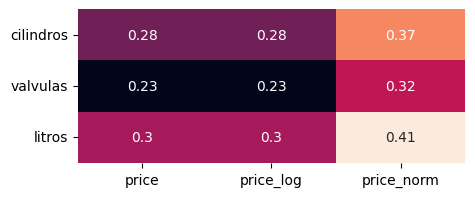

In [125]:
plt.figure(figsize=(5,2))
sea.heatmap(corr, annot=True, fmt='.2g', cbar=False)
plt.show()

#### Imputando para valvulas e cilindros

In [126]:
trat[['cilindros','valvulas','litros']].isnull().sum()

cilindros      821
valvulas     19724
litros        2536
dtype: int64

In [127]:
trat.groupby(by=['cilindros','litros'])['valvulas'].agg(pd.Series.mode)

cilindros  litros
I3         1.0       12V
           1.2       12V
           1.3       12V
           1.5       12V
I4         1.2       16V
                    ... 
V8         6.6        []
           6.7       32V
           7.0       16V
           7.3        []
           7.5        []
Name: valvulas, Length: 117, dtype: object

> Tem valores [] serão tratados como `<NA>`

Essa função se encarrega de solucionar esse problema

In [128]:
def imputa_moda(group):
    try:
        return group.mode()[0]
    except KeyError:
        return pd.NA

In [129]:
imput_litros = trat.groupby(['cilindros'])['litros'].transform(lambda x: x.fillna(imputa_moda(x)))
pd.concat([imput_litros[0:10], trat['litros'][0:10]], axis=1)

,litros,litros
0,3.6,<NA>
1,5.6,5.6
2,5.7,5.7
3,3.5,3.5
5,3.6,3.6
6,4.4,4.4
7,2.3,2.3
8,3.6,3.6
10,1.8,1.8
11,2.0,2.0


In [130]:
imput_litros.isna().sum()

825

> Para os valores nulos serão imputados a moda dos atributos categoricos

Valores nulos serão imputados com base no :
litros : será imputado com base no cilindros
valvulas:com base no cilindros e litros

In [131]:
from sklearn.impute import KNNImputer
class ImputandoCVL(BaseEstimator, TransformerMixin):
    def __init__(self):pass
    def fit(self, X, y=None):return self

    def transform(self, X, y=None):
        #Imputando litros
        X['litros'] = X.groupby('cilindros')['litros']\
                        .transform( lambda x: x.fillna(self.imputa_moda(x)) )



        #Imputando para valvulas
        X['valvulas'] = X.groupby(by=['cilindros','litros'])['valvulas']\
                         .transform( lambda x: x.fillna(self.imputa_moda(x)) )

        return X
    # Essa função retorna a moda , caso o valor da moda seja = []
    # dará o KeyError ele retornará um <NA>
    def imputa_moda(self, group):
        try:
            return group.mode()[0]
        except KeyError:
            return pd.NA

In [132]:
imput = ImputandoCVL()

In [133]:
trat = imput.fit_transform(trat)

In [134]:
trat[['cilindros','valvulas','litros']].isnull().sum()

cilindros     821
valvulas     1262
litros        825
dtype: int64

> Há uma ganho de correlação no tratamento dessa coluna todas elas serão utilizada para o algoritmo de regressão
> Será removido o engine_add

#### Verificando novamente a correlação com os atributos com o target transformado

In [135]:
# Verificando a correlação
corr  = trat.select_dtypes(exclude=[object])\
        .corr()[['price_norm','price_log','price']]

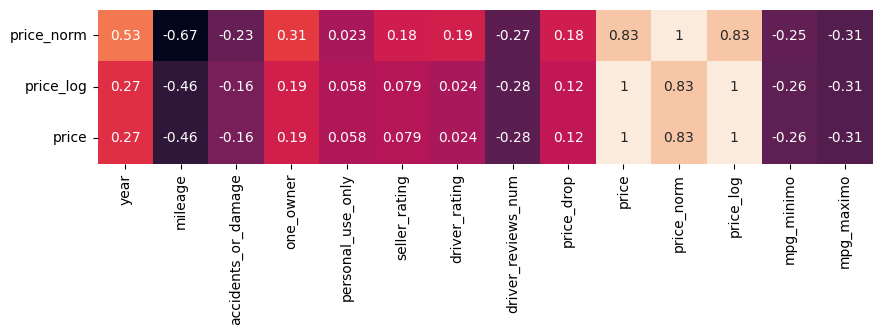

In [136]:
plt.figure(figsize=(10,2))
sea.heatmap(corr.T, annot=True, fmt='.2g', cbar=False)
plt.show()

> Esses atributos serão utilizado para a classificação

In [137]:
col_cat.remove('engine')

In [138]:
# Verificando a correlação
corr = Correlation(col_cat, ['price_norm','price_log','price'], trat).pointBisserl()

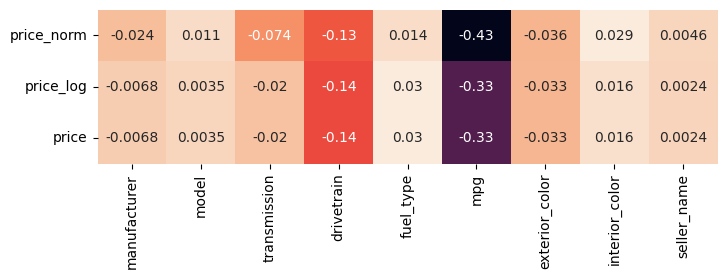

In [139]:
# Plotando para melhor visualização
plt.figure(figsize=(8,2))
sea.heatmap(corr, annot=True, fmt='.2g', cbar=False)
plt.show()

> Se manteve a correlação de antes, ou seja, baixa. não serão utilizados

Unido cores em uma unica coluna chamada `interior_exterior_color`

In [140]:
class ColorCar(BaseEstimator, TransformerMixin):
    def __init__(self):pass
    def fit(self, X, y=None):return self
    def transform(self, X, y=None):
        X['interior_exterior_color'] = (
            X['interior_color'].str.upper()+'-'+X['exterior_color'].str.upper()
        )
        return X

In [141]:
trat = ColorCar().fit_transform(trat.dropna())

In [142]:
corr = Correlation(
    ['interior_exterior_color'], ['price', 'price_log','price_norm'], trat
                   ).pointBisserl()

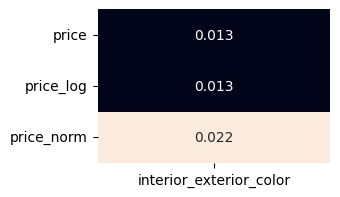

In [143]:
# Plotando para melhor visualização
plt.figure(figsize=(3,2))
sea.heatmap(corr, annot=True, fmt='.2g', cbar=False)
plt.show()

> Não houve ganho de informação/ aumento da correlação fazendo esse tratamento

#### Tratamento para a coluna trasmissão, e depois verificar se a correlaçao
> Se há aumento na correlação

In [144]:

trat['transmission'].unique()

array(['Automatic', '7-Speed Automatic', '6-Speed Automatic',
       '8-Speed Automatic', 'Automatic with Tiptronic',
       '10-Speed Automatic', '9-Speed Automatic', '5-Speed Automatic',
       'Automatic CVT', '6-Speed Manual',
       '7-Speed Automatic with Auto-Shift',
       '6-Speed Automatic with Auto-Shift', 'Variable',
       '8-Speed Automatic with Auto-Shift', 'Manual', 'Automatic 8-Speed',
       '4-Speed Manual', '9-SPEED A/T',
       '10-Speed Automatic with Overdrive', '6-Speed',
       '4-Speed Automatic', 'CVT', '6-SPEED A/T',
       '8-Speed Automatic with Tiptronic', 'Auto, 6-Spd Seq Mode',
       'CVT with Xtronic', '9-Speed Shiftable Automatic',
       'CVT Lineartronic', '5-Speed Manual', 'Auto, 7-Spd Rev Matching',
       '9-Speed 948TE Automatic', 'automatic', '7-Speed Manual',
       '8-Speed Shiftable Automatic', '8-SPEED AUTOMATIC (850RE)',
       '6-Speed Automatic with Sequential Shift ECT', 'NOT SPECIFIED',
       'Lineartronic CVT', '6-Speed Automatic wi

> Dados incosistente, exemplo:
* Há valores simplificados como Speed escrito como Spd ,como também o automatic escrito A/T ou A
> A coluna só terá {numero}-speed ou manual automatica

In [145]:
import re
class TratamentoTransmissão(BaseEstimator, TransformerMixin):
    def __init__(self):pass
    def fit(self, X, y=None):return self
    def transform(self, X, y=None):
        X['transmission'] = X['transmission'].str.lower()
        X['transmission'] = X['transmission'].str.replace('a/t','automatic ')
        X['transmission'] = X['transmission'].str.replace('spd','speed')
        X['transmission'] = X['transmission'].str.replace('w/',' with')
        X['transmission'] = X['transmission'].str.replace('m/t',' with')
        X['transmission'] = X['transmission'].str.replace('m','manual')
        X['transmission'] = X['transmission'].str.replace('(pkd)','')
        X['transmission'] = X['transmission'].apply(self.speed_padrao)
        X['transmission'] = X['transmission'].apply(self.transmissao)

        return X
    def speed_padrao(self, text):
        if str(text)!= 'nan':
            string = r'(\d+)\s*speed'
            speed  = re.sub(string, r'\1-speed', text)
            return speed
        return np.NAN


    def transmissao(self, text):
        palavra = copy.deepcopy(text)
        string  = ''
        if str(text) == 'nan':
            return pd.NA

        speed = r"(\d+)-speed"

        #verificando se na string tem {numero}-speed
        is_speed = re.search(speed, text)

        if is_speed:
            string += is_speed.group(0)+' '
        if 'manual' in palavra:
            string += 'manual'
        elif 'auto'   in palavra:
            string += 'automatic'

        if len(string) == 0:
            return pd.NA
        return string

In [146]:
trat = TratamentoTransmissão().fit_transform(trat)

In [147]:
trat['transmission'].unique()

array(['manual', '7-speed manual', '6-speed manual', '8-speed manual',
       '10-speed manual', '9-speed manual', '5-speed manual', <NA>,
       '4-speed manual', '6-speed ', '7-speed ', '6-speed automatic',
       'automatic', '5-speed ', '1-speed manual', '7-speed automatic',
       '8-speed ', '3-speed manual', '8-speed automatic'], dtype=object)

In [148]:
corr = Correlation(['transmission'], ['price', 'price_log','price_norm'], trat
                   ).pointBisserl()

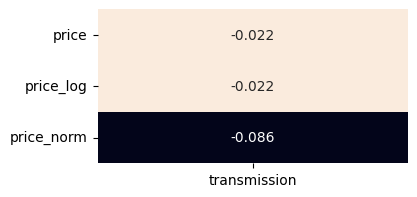

In [149]:
# Plotando para melhor visualização
plt.figure(figsize=(4,2))
sea.heatmap(corr, annot=True, fmt='.2g', cbar=False)
plt.show()

#### A classe abaixo servirá para a validação cruzada para verificar se meu modelo está generalizando bem
> Estou fazendo isso para evitar a repetição de código

In [150]:
import numpy as np
from sklearn.base import clone

class validacao_cruzada:
    def validacao(self, x, y, model, num_split=5, dtype='sk', random=1, inverse=False, transformed='log'):
        fold = KFold(n_splits=num_split, shuffle=True, random_state=random)
        media_mae = []
        media_r_2 = []

        for iter, (train, test) in enumerate(fold.split(x)):

            xtrain, xtest = x[train, :], x[test,:]
            ytrain, ytest = y[train], y[test]
            print('_'*80)
            print(f'KFold {iter}')
            if dtype =='sk' :modelf = clone(model)
            else            :modelf = copy.deepcopy(model)

            modelf.fit(xtrain, ytrain)
            pred = modelf.predict(xtest)
            if inverse:
                match transformed:
                    case 'log':
                        ytest, pred = np.expm1(ytest), np.expm1(pred)

            MAE = mean_absolute_error(ytest, pred)
            r_2 = r2_score(ytest, pred)

            print(f' > Erro médio absoluto :{MAE:.5f}   r2_score : {r_2:.5f}')
            media_mae.append(MAE);media_r_2.append(r_2)
        print('_'*80)
        print(f'Media MAE......: {np.mean(MAE):.5f}',       '\n',
              f'Media R2_score.: {np.mean(r_2):.5f}',       '\n',
              f'Desvio Padrão MAE: {np.std(media_mae):.5f}','\n',
              f'Desvio Padrão R_2: {np.std(media_r_2):.5f}'
              )

> A cada iteração ele irá imprimir o erro medio absoluto e r2_score e ao final e media de ambos na iteração


#### Construindo a pipiline

In [151]:
pipeline = Pipeline(
    steps = [
        # Valor duplicados
        ('Removendo_duplicadas',
            DropDuplicadas()
        ),
        #
        # Remove colunas de baixa correlação
        ('Removendo_colunas',
            RemovendoAtributos(
                ['manufacturer'  , 'transmission', 'price_drop',
                 'exterior_color', 'interior_color',
                 'seller_name'   , 'personal_use_only',
                  'model', 'seller_rating',
                ]
            )
        ),
        ('imputing_milage',
            Imputing(column='mileage', mode='media')
        ),
        # Tratanco incossitencias de divertrain
        ('Incosistencias_drivertrain',
            TratandoInconsistenciaDrivetrain()
        ),
        ('Incosistencias_mpg_1',
            ImputingGasoMpg()
        ),
        # Tratando mpg
        ('Incosistencias_mpg_2',
            TratandoIncositencia()
        ),
        ('Imputing_mpg',
            ImputingMpg()
        ),
        # Removendo valores nulos
        ('Removendo_nan',
            RemovendoValoresNulos(None)
        ),
        ('Dividindo_max_min_mpg',
            MpgMaxMin()
        ),
        ('Removendo_coluna_2',
            RemovendoAtributos(['mpg','fuel_type'])
        ),
        # Criando novas colunas, o que foi feito acima
        ('Tranformando_engine',
            CriandoNovasColunas()
        ),
        # Imputando valvulas e litros
        ('Imputano_valvulas_litros',
            ImputandoCVL()
        ),
        ('Removendo_nan_2',
            RemovendoValoresNulos(None)
        ),
        # Escalonando atributos numericos
        ('Padronização',
            Padronizacao(['year', 'driver_reviews_num',
                          'mileage', 'mpg_maximo',
                          'mpg_minimo', 'driver_rating','litros'
                          ])
        ),
        # Removendo atributos
        ('Removendo_colunas_2',
            RemovendoAtributos(['engine'])
        ),
        # OneHotEncoder dos atributos categoricos ordinal
        ('dummies',
            Dummies(['cilindros','valvulas',
                     'accidents_or_damage',	'one_owner',
                     'drivetrain'
                     ])

        ),
        # Usarei a transformação normal
        ('Tranformando_target_logaritimica',
            TransformancaoTarget(['price'],dtype='norm')
        ),
    ]
)

> Imputar zeros no nan no price_drop não fez as metricas do modelo melhorar

In [152]:
pipeline

Pipeline(steps=[('Removendo_duplicadas', DropDuplicadas()),
                ('Removendo_colunas',
                 RemovendoAtributos(columns=['manufacturer', 'transmission',
                                             'price_drop', 'exterior_color',
                                             'interior_color', 'seller_name',
                                             'personal_use_only', 'model',
                                             'seller_rating'])),
                ('imputing_milage', Imputing(column='mileage', mode='media')),
                ('Incosistencias_drivertrain',
                 TratandoInconsi...
                 Padronizacao(columns=['year', 'driver_reviews_num', 'mileage',
                                       'mpg_maximo', 'mpg_minimo',
                                       'driver_rating', 'litros'])),
                ('Removendo_colunas_2', RemovendoAtributos(columns=['engine'])),
                ('dummies',
                 Dummies(columns=['cilindros', 'valvulas',
                                  'accidents_or_damage', 'one_owner',
                                  'drivetrain'])),
                ('Tranformando_target_logaritimica',
                 TransformancaoTarget(column=['price']))])

In [153]:
# Repetindo a leitura e a amostra
dataset = pd.read_csv('/content/drive/MyDrive/Dataset/cars.csv')

Defindo o dataset 25%

In [154]:
data = dataset.sample(frac=0.25, random_state=1)

Reordenando indices

In [155]:
data.reset_index(drop=True, inplace=True)

In [156]:
dataset = pipeline.fit_transform(data)

In [157]:
dataset.head(3)

,year,mileage,driver_rating,driver_reviews_num,price,mpg_minimo,mpg_maximo,litros,cilindros_I3,cilindros_I4,...,valvulas_4V,valvulas_8V,accidents_or_damage_0.0,accidents_or_damage_1.0,one_owner_0.0,one_owner_1.0,drivetrain_All Wheel Drive,drivetrain_Four Wheel Drive,drivetrain_Front Wheel Drive,drivetrain_Rear Wheel Drive
0,0.068408,-0.602671,-2.685393,-0.483533,1.562571,-0.794809,-0.896448,0.551646,0,0,...,0,0,1,0,0,1,0,1,0,0
1,-0.190140,0.101144,0.243641,-0.210769,0.140754,-1.321794,-1.544081,2.233414,0,0,...,0,0,1,0,1,0,0,0,0,1
3,-0.707236,0.733463,0.243641,-0.243831,-0.768381,-0.092163,0.398818,0.467557,0,0,...,0,0,1,0,0,1,0,0,1,0


> Poderia está usando outra forma de tranformar esse dados ao invés a classe pipeline. Mas eu utilizo ela pois mantém a estrutura de dataframe, utilizando outras formas eu teria que passar o dataframe para uma estruta de array numpy

In [158]:
dataset.shape

(145984, 39)

In [159]:
dataset.columns

Index(['year', 'mileage', 'driver_rating', 'driver_reviews_num', 'price',
       'mpg_minimo', 'mpg_maximo', 'litros', 'cilindros_I3', 'cilindros_I4',
       'cilindros_I5', 'cilindros_I6', 'cilindros_V10', 'cilindros_V12',
       'cilindros_V4', 'cilindros_V6', 'cilindros_V8', 'valvulas_12V',
       'valvulas_16V', 'valvulas_18V', 'valvulas_20V', 'valvulas_24V',
       'valvulas_2V', 'valvulas_30V', 'valvulas_32V', 'valvulas_36V',
       'valvulas_3V', 'valvulas_40V', 'valvulas_48V', 'valvulas_4V',
       'valvulas_8V', 'accidents_or_damage_0.0', 'accidents_or_damage_1.0',
       'one_owner_0.0', 'one_owner_1.0', 'drivetrain_All Wheel Drive',
       'drivetrain_Four Wheel Drive', 'drivetrain_Front Wheel Drive',
       'drivetrain_Rear Wheel Drive'],
      dtype='object')

#### definindo conj. de treinamento e conj. de teste
* Além dos algoritmos de M.L

In [160]:
from sklearn.experimental    import enable_halving_search_cv
from sklearn.model_selection import (
    KFold ,             # Para validação cruzada
    train_test_split ,  # Para definir o train|test
    GridSearchCV     ,  # Para encontrar os melhores hyperparametros do Algoritmos
    RandomizedSearchCV, # ''''''''
    HalvingGridSearchCV,
    cross_val_score
)

from sklearn.metrics import (
    r2_score,
    mean_squared_error,
    mean_absolute_error,
    PredictionErrorDisplay

)
from sklearn.neighbors import KNeighborsRegressor

# Algoritmos do sklearn
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import (
    VotingRegressor,
    RandomForestRegressor,
    GradientBoostingRegressor,
    BaggingRegressor,
    AdaBoostRegressor
)
from sklearn.linear_model import(
    SGDRegressor,
    LinearRegression,
    Ridge,
    BayesianRidge,
    PassiveAggressiveRegressor
)
from sklearn.svm          import LinearSVR, SVR
# Rede Neural do tensorflow
import keras

#Optimin
from hyperopt import hp, fmin, tpe, Trials, STATUS_OK

# Para avaliação do modelo
from yellowbrick.regressor import ResidualsPlot

Definindo o conj. treinamento e de teste

In [161]:
X = dataset.drop(columns=['price'])
y = dataset['price']

In [162]:
X.shape

(145984, 38)

In [163]:
xtrain, xtest, ytrain, ytest = train_test_split(
    X.values, y.values, test_size=0.30, random_state=42
    )

In [164]:
y.describe()

count    145984.000000
mean         -0.001444
std           1.005290
min          -5.199338
25%          -0.683690
50%           0.005018
75%           0.686675
max           5.199338
Name: price, dtype: float64

In [165]:
dataset.isna().sum()

year                            0
mileage                         0
driver_rating                   0
driver_reviews_num              0
price                           0
mpg_minimo                      0
mpg_maximo                      0
litros                          0
cilindros_I3                    0
cilindros_I4                    0
cilindros_I5                    0
cilindros_I6                    0
cilindros_V10                   0
cilindros_V12                   0
cilindros_V4                    0
cilindros_V6                    0
cilindros_V8                    0
valvulas_12V                    0
valvulas_16V                    0
valvulas_18V                    0
valvulas_20V                    0
valvulas_24V                    0
valvulas_2V                     0
valvulas_30V                    0
valvulas_32V                    0
valvulas_36V                    0
valvulas_3V                     0
valvulas_40V                    0
valvulas_48V                    0
valvulas_4V   

&nbsp;

## Usarei o método ensemble votingRegressor unindo os melhores algoritmos

A métrica utilizada será o r2_score que me informa o quando meu modelo está se ajustando aos dados:

    * Mais proximo de 1 melhor é meu modelo

Também, erro medio absoluto que me informa a diferença média entre o target e o valor previsto, não usarei o quadratico pois o target passou por uma transformação assim reduz os outliers

> Por que que estou utilizando o ensemble pois e um dos melhores maneiras de construir um modelo

#### Usando o Arvoré de decisão GradientBoost

* Irei primeiro encontrar melhores hiparametros para árvore de decisão e depois usar no GradientBoost

In [166]:
tree = DecisionTreeRegressor()
tree.fit(xtrain, ytrain)

DecisionTreeRegressor()

> Arvore de decisão se não regularizada tende a overfiting, ou seja, não generaliza bem só tem bons resultados com o conj de treinamento

In [167]:
print(f"profundidade da arvore.: {tree.get_depth()}")
print(f"Número de folhas.......: {tree.get_n_leaves()}")
print(f"Número de nós..........: {tree.tree_.node_count}")

profundidade da arvore.: 42
Número de folhas.......: 101429
Número de nós..........: 202857


> Arvore será podada, uma forma de regularizar

In [168]:
random = np.random.RandomState(seed=42)
params = dict(
    max_depth = random.randint(34,40,size=6),
    min_samples_split = np.arange(500,1000,100),
    min_samples_leaf  = np.arange(100,800,100),
)
estimador = DecisionTreeRegressor()
grid_tree = HalvingGridSearchCV(estimador, param_grid=params, cv=5, scoring='r2')

> Essa foram o hipyparamentros definidos no qual o gridSearch usará para encontrar o melhor

In [169]:
grid_tree.fit(xtrain, ytrain)

HalvingGridSearchCV(estimator=DecisionTreeRegressor(),
                    param_grid={'max_depth': array([37, 38, 36, 38, 38, 35]),
                                'min_samples_leaf': array([100, 200, 300, 400, 500, 600, 700]),
                                'min_samples_split': array([500, 600, 700, 800, 900])},
                    scoring='r2')

In [170]:
print('Melhor estimador..:', grid_tree.best_estimator_)
print('Scoring...........:', grid_tree.best_score_)

Melhor estimador..: DecisionTreeRegressor(max_depth=36, min_samples_leaf=100, min_samples_split=500)
Scoring...........: 0.8208471013544069


> Vou pegas esse hiperparametros e aplicar na Floresta Aleatória e no GradientBoosting

Usando Gradient Boosting

In [171]:
gradiente =  GradientBoostingRegressor(
    n_estimators=50,
    max_depth   =36,
    min_samples_leaf=100,
    min_samples_split=500
    )
gradiente.fit(xtrain, ytrain)

GradientBoostingRegressor(max_depth=36, min_samples_leaf=100,
                          min_samples_split=500, n_estimators=50)

In [172]:
pred_grad = gradiente.predict(xtest)

In [173]:
print('Erro medio absolulo..:', mean_absolute_error(ytest, pred_grad))
print('R2_score.............:', r2_score(ytest, pred_grad))

Erro medio absolulo..: 0.2112076700256485
R2_score.............: 0.9134538137814605


Fazendo a validação cruzada para ver se o modelo está generalizando bem

In [174]:
validacao_cruzada().validacao(xtrain, ytrain, gradiente)

________________________________________________________________________________
KFold 0
 > Erro médio absoluto :0.21701   r2_score : 0.90898
________________________________________________________________________________
KFold 1
 > Erro médio absoluto :0.21408   r2_score : 0.91011
________________________________________________________________________________
KFold 2
 > Erro médio absoluto :0.21932   r2_score : 0.90358
________________________________________________________________________________
KFold 3
 > Erro médio absoluto :0.21644   r2_score : 0.90804
________________________________________________________________________________
KFold 4
 > Erro médio absoluto :0.21912   r2_score : 0.90280
________________________________________________________________________________
Media MAE......: 0.21912 
 Media R2_score.: 0.90280 
 Desvio Padrão MAE: 0.00192 
 Desvio Padrão R_2: 0.00295


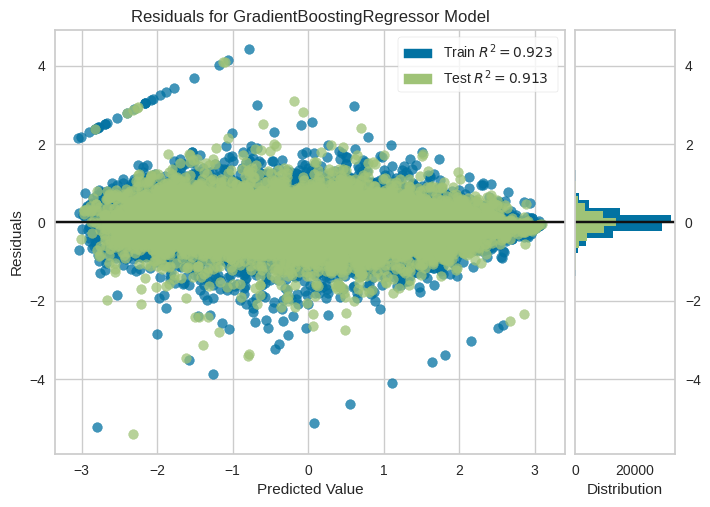

<Axes: title={'center': 'Residuals for GradientBoostingRegressor Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [175]:
residuo = ResidualsPlot(gradiente)

residuo.fit(xtrain, ytrain)
residuo.score(xtest, ytest)
residuo.show()

> Meu modelo está ajustando bem

### Keras

In [176]:
xtrain.shape

(102188, 38)

In [177]:
len(xtrain)//32

3193

Criando uma classe de regressão usando uma rede neural do keras
> Estou fazendo essa classe pois e ideia é utiliza-la no voting regressor

In [178]:
from functools    import partial
from sklearn.base import RegressorMixin
class Neural(RegressorMixin):
    model = None

    def __init__(self, verbose=0, batch_size=32, epoch=10,validation_split=0.1, patience=3):
        self.verbose  = verbose
        self.epoch    = epoch
        self.batch    = batch_size
        self.patience = patience
        self.validation_split = validation_split

    def fit(self, X, y):
        self.model = self.model()
        # E uma tecnica que regularização
        # Se o modelo a perda estiver aumentando ele encerra o treinamento

        stopping = keras.callbacks.EarlyStopping(monitor='loss', patience=self.patience)
        self.model.compile(
            optimizer = keras.optimizers.RMSprop(clipnorm=1, momentum=0.99),
            loss      = keras.metrics.mae,
        )
        self.model.fit(X, y, batch_size=self.batch, epochs=self.epoch, validation_split=self.validation_split, verbose=self.verbose)

        return self

    def model(self):
        # Usando inicialização dos peso com base na função ativação
        # para evitar a explosão | fuga dos gradientes
        # ELU é uma variante da Relu
        # Normalização de batch
        Dense = partial(
            keras.layers.Dense,
            kernel_initializer = keras.initializers.he_normal
        )
        BatchNorm = partial(
            keras.layers.BatchNormalization,
        )
        model = keras.models.Sequential(
            layers = [
                Dense(90, use_bias=False),
                BatchNorm(),
                keras.layers.ELU(),

                Dense(45, use_bias=False),
                BatchNorm(),
                keras.layers.ELU(),

                Dense(28, use_bias=False),
                BatchNorm(),
                keras.layers.ELU(),

                Dense(14, use_bias=False),
                BatchNorm(),
                keras.layers.ELU(),

                Dense(8, use_bias=False),
                BatchNorm(),
                keras.layers.ELU(),

                Dense(4, use_bias=False),
                BatchNorm(),
                keras.layers.ELU(),

                Dense(2, use_bias=False),
                BatchNorm(),
                keras.layers.ELU(),

                Dense(1,
                    bias_initializer=keras.initializers.RandomNormal(
                        mean=0.0, stddev=0.05, seed=1
                    )
                ),
            ]
        )
        return model

    def predict(self, X, y=None): return self.model.predict(X).reshape(1, -1)[0]

    # Essa função e para o voting regressor
    # funcionar com o uso do keras
    def get_params(self, deep=True):
        return dict( verbose    = self.verbose,
                     batch_size = self.batch,
                     epoch      = self.epoch,
                     validation_split   = self.validation_split,
                     patience = self.patience
                     )

> Poderia usar ativação `RELU` mas como é uma grande quantidade de dados o modelo fica lendo então vou utilizar um variante da função de ativação `relu` a ELU. \

In [179]:
model = Neural(verbose=1, patience=3, batch_size=28, epoch=5,validation_split=None)

In [180]:
model.fit(xtrain, ytrain)

Epoch 1/5
3650/3650 [==============================] - 22s 5ms/step - loss: 0.4051
Epoch 2/5
3650/3650 [==============================] - 15s 4ms/step - loss: 0.3808
Epoch 3/5
3650/3650 [==============================] - 15s 4ms/step - loss: 0.3766
Epoch 4/5
3650/3650 [==============================] - 15s 4ms/step - loss: 0.3735
Epoch 5/5
3650/3650 [==============================] - 15s 4ms/step - loss: 0.3655


In [181]:
pred_dnn = model.predict(xtest)

1369/1369 [==============================] - 4s 3ms/step


In [182]:
print('Erro medio absolulo..:', mean_absolute_error(ytest, pred_dnn))
print('R2_score.............:', r2_score(ytest, pred_dnn))

Erro medio absolulo..: 0.2974185600577628
R2_score.............: 0.8416124278390489


Modelo para validação cruzada e para o método ensemble se obter bom desempenho na validação cruzada

In [183]:
model_cv = Neural(patience=3, batch_size=28, epoch=5,validation_split=None)

In [184]:
validacao_cruzada().validacao(xtrain, ytrain, model_cv, num_split=4, dtype=5)

________________________________________________________________________________
KFold 0
799/799 [==============================] - 1s 2ms/step
 > Erro médio absoluto :0.29803   r2_score : 0.84252
________________________________________________________________________________
KFold 1
799/799 [==============================] - 2s 3ms/step
 > Erro médio absoluto :0.29697   r2_score : 0.83475
________________________________________________________________________________
KFold 2
799/799 [==============================] - 1s 2ms/step
 > Erro médio absoluto :0.30997   r2_score : 0.82735
________________________________________________________________________________
KFold 3
799/799 [==============================] - 1s 2ms/step
 > Erro médio absoluto :0.29137   r2_score : 0.83779
________________________________________________________________________________
Media MAE......: 0.29137 
 Media R2_score.: 0.83779 
 Desvio Padrão MAE: 0.00677 
 Desvio Padrão R_2: 0.00551


> Resultados bons mas não melhor que o gradiente boost

### Ridge

In [185]:
random = np.random.RandomState(seed=32)

penalty_p  = ['l1', 'elasticnet','l2']
alpha_p    = random.uniform(0.0001, 0.1, 10).tolist()
l1_ratio_p = random.uniform(0.1, 0.9, 5).tolist()
lr         = ['optimal', 'invscaling']

params = dict(
    penalty = hp.choice('penalty',penalty_p),
    alpha    =hp.choice('alpha'  ,alpha_p),
    l1_ratio =hp.choice('l1_ratio',l1_ratio_p),
    )
def objective(params):
    sgd = SGDRegressor(max_iter=6000,**params)
    score = -1*(cross_val_score(sgd, xtrain, ytrain, cv=4, scoring='r2').mean())
    return {'loss': score, 'status': STATUS_OK}

In [186]:
trials = Trials()
best = fmin(fn=objective, space=params, algo=tpe.suggest, max_evals=10, trials=trials)

100%|██████████| 10/10 [00:12<00:00,  1.29s/trial, best loss: -0.7556704353117303]


In [187]:
best_params = dict(
    penalty = penalty_p[best['penalty']],
    alpha   =  alpha_p[best['alpha']],
    l1_ratio =  l1_ratio_p[best['l1_ratio']]
)
best_params

{'penalty': 'l2',
 'alpha': 0.01019854737483161,
 'l1_ratio': 0.17342730783696164}

In [188]:
bay = SGDRegressor(**best_params)
bay.fit(xtrain, ytrain)

SGDRegressor(alpha=0.01019854737483161, l1_ratio=0.17342730783696164)

In [189]:
pred = bay.predict(xtest)

In [190]:
print('Erro medio absolulo..:', mean_absolute_error(ytest, pred))
print('R2_score.............:', r2_score(ytest, pred))

Erro medio absolulo..: 0.37917373519024117
R2_score.............: 0.7578052586729096


> Bom modelo mas não se compara ao GradientBoosting

### LinearSvr

In [191]:
linear_svr = LinearSVR(C=1, loss='squared_epsilon_insensitive', max_iter=5000, dual=False)
linear_svr.fit(xtrain, ytrain)

LinearSVR(C=1, dual=False, loss='squared_epsilon_insensitive', max_iter=5000)

In [192]:
pred_svr = linear_svr.predict(xtest)

In [193]:
print('Erro medio absolulo..:', mean_absolute_error(ytest, pred_svr))
print('R2_score.............:', r2_score(ytest, pred_svr))

Erro medio absolulo..: 0.37502588053062524
R2_score.............: 0.7623895461541914


In [194]:
validacao_cruzada().validacao(xtrain, ytrain, linear_svr, random=1)

________________________________________________________________________________
KFold 0
 > Erro médio absoluto :0.37501   r2_score : 0.76169
________________________________________________________________________________
KFold 1
 > Erro médio absoluto :0.36991   r2_score : 0.76437
________________________________________________________________________________
KFold 2
 > Erro médio absoluto :0.37606   r2_score : 0.75760
________________________________________________________________________________
KFold 3
 > Erro médio absoluto :0.37446   r2_score : 0.76190
________________________________________________________________________________
KFold 4
 > Erro médio absoluto :0.37270   r2_score : 0.75323
________________________________________________________________________________
Media MAE......: 0.37270 
 Media R2_score.: 0.75323 
 Desvio Padrão MAE: 0.00215 
 Desvio Padrão R_2: 0.00392


> Bom modelo mas não se compara ao GradientBoosting

### KNN

In [195]:
random = np.random.RandomState(seed=32)

n_neighbors_p = np.arange(4, 7).tolist()
algorithm_p   = ['ball_tree', 'kd_tree']
leaf_size_p   = np.array([20,25])
p_p           = [1,2]
params = dict(
    n_neighbors = hp.choice('n_neighbors', n_neighbors_p ),
    algorithm   = hp.choice('algorithm'  , algorithm_p   ),
    leaf_size   = hp.choice('leaf_size', leaf_size_p),
    p           = hp.choice('p', p_p)
)

def objective(params):
    knn   = KNeighborsRegressor(**params)
    score = round(-1*cross_val_score(knn, xtrain, ytrain, cv=4, scoring='r2').mean(),4)

    return {'loss': score, 'status': STATUS_OK}

In [196]:
trials = Trials()
best = fmin(
    fn=objective,
    space = params,
    algo  = tpe.suggest,
    max_evals=5,
    trials   =trials, rstate=np.random.default_rng(42)
)

100%|██████████| 5/5 [20:44<00:00, 248.91s/trial, best loss: -0.8956]


In [197]:
best_params = dict(
    n_neighbors = n_neighbors_p[best['n_neighbors']],
    leaf_size   = leaf_size_p[best['leaf_size']],
    p           = p_p[best['p']],
    algorithm   = algorithm_p[best['algorithm']]

)
best_params

{'n_neighbors': 6, 'leaf_size': 25, 'p': 1, 'algorithm': 'kd_tree'}

In [198]:
knn = KNeighborsRegressor(**{'n_neighbors': 6,
                             'leaf_size': 25,
                             'p': 1,
                             'algorithm': 'kd_tree'})
knn.fit(xtrain, ytrain)

KNeighborsRegressor(algorithm='kd_tree', leaf_size=25, n_neighbors=6, p=1)

In [199]:
pred_knn = knn.predict(xtest)

In [200]:
print('Erro medio absolulo..:', mean_absolute_error(ytest, pred_knn))
print('R2_score.............:', r2_score(ytest, pred_knn))

Erro medio absolulo..: 0.21732102651118176
R2_score.............: 0.9045298850753016


In [201]:
validacao_cruzada().validacao(xtrain, ytrain, knn, random=32)

________________________________________________________________________________
KFold 0
 > Erro médio absoluto :0.22181   r2_score : 0.89786
________________________________________________________________________________
KFold 1
 > Erro médio absoluto :0.22268   r2_score : 0.90019
________________________________________________________________________________
KFold 2
 > Erro médio absoluto :0.22454   r2_score : 0.89640
________________________________________________________________________________
KFold 3
 > Erro médio absoluto :0.22465   r2_score : 0.89524
________________________________________________________________________________
KFold 4
 > Erro médio absoluto :0.22228   r2_score : 0.89545
________________________________________________________________________________
Media MAE......: 0.22228 
 Media R2_score.: 0.89545 
 Desvio Padrão MAE: 0.00118 
 Desvio Padrão R_2: 0.00183


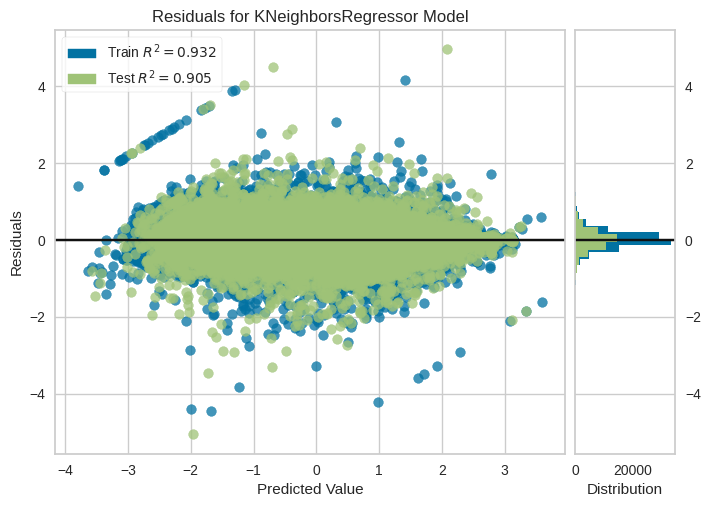

<Axes: title={'center': 'Residuals for KNeighborsRegressor Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [202]:
residuo = ResidualsPlot(knn)

residuo.fit(xtrain, ytrain)
residuo.score(xtest, ytest)
residuo.show()

> Desempenho similar ao gradientBoosting será utilizado o votingRegressor

### Voting Regressor

**Pergunta**: Analisando essas métricas, qual é a conclusão que vocês chegam? A performance do modelo foi boa ou ruim?
> Resposta abaixo

In [203]:
voting = VotingRegressor(
    estimators = [
        ('florest_aleatoria',
            GradientBoostingRegressor(
                    n_estimators=50,
                    max_depth   =36,
                    min_samples_leaf=100,
                    min_samples_split=500
            )
        ),
        ('knn',
            KNeighborsRegressor(**{'n_neighbors': 7,
                                   'leaf_size': 30,
                                   'p': 1,
                                   'algorithm': 'ball_tree'}
                                )
        )
    ]
)

In [204]:
voting.fit(xtrain, ytrain)

VotingRegressor(estimators=[('florest_aleatoria',
                             GradientBoostingRegressor(max_depth=36,
                                                       min_samples_leaf=100,
                                                       min_samples_split=500,
                                                       n_estimators=50)),
                            ('knn',
                             KNeighborsRegressor(algorithm='ball_tree',
                                                 n_neighbors=7, p=1))])

In [205]:
pred_vot = voting.predict(xtest)

In [206]:
print('Erro medio absolulo..:', mean_absolute_error(ytest, pred_vot))
print('R2_score.............:', r2_score(ytest, pred_vot))

Erro medio absolulo..: 0.2028882081290371
R2_score.............: 0.9183959696444075


In [207]:
validacao_cruzada().validacao(xtrain, ytrain, voting)

________________________________________________________________________________
KFold 0
 > Erro médio absoluto :0.20800   r2_score : 0.91418
________________________________________________________________________________
KFold 1
 > Erro médio absoluto :0.20506   r2_score : 0.91619
________________________________________________________________________________
KFold 2
 > Erro médio absoluto :0.21072   r2_score : 0.91005
________________________________________________________________________________
KFold 3
 > Erro médio absoluto :0.20846   r2_score : 0.91366
________________________________________________________________________________
KFold 4
 > Erro médio absoluto :0.20948   r2_score : 0.90853
________________________________________________________________________________
Media MAE......: 0.20948 
 Media R2_score.: 0.90853 
 Desvio Padrão MAE: 0.00189 
 Desvio Padrão R_2: 0.00281


In [215]:
from sklearn.model_selection import cross_val_score, RepeatedKFold

repeated = RepeatedKFold(n_splits=4, n_repeats=3, random_state=42)
cross_val_score(voting, xtrain, ytrain, cv=repeated, scoring='r2')

array([0.91409812, 0.91435738, 0.9092432 , 0.90832731, 0.91076109,
       0.90971456, 0.9143085 , 0.91072692, 0.91303606, 0.91101815,
       0.91066263, 0.91161055])

Sim utlizando o metodo ensemble votingRegressor pegando os algoritmos com melhores resultados. \
> Unindo 2 modelos de regressão diferentes ajuda evitar overfiting

O modelo está generelizando bem pois a validação cruzada os fold não há disparidade dos valores das metricas r2_score e Erro médio absuto

Tranformaçao inversa, quando eu quiser saber o valor real do target

In [208]:
a = pipeline[len(pipeline)-1].inverse(pred_vot.reshape(-1, 1)).reshape(1, -1)[0]
b = pipeline[len(pipeline)-1].inverse(ytest.reshape(-1, 1)).reshape(1, -1)[0]

In [209]:
predL = []
realL = []
for e, (p, r) in enumerate(zip(a, b)):
    predL.append(round(p, 2))
    realL.append(r)

pd.DataFrame({'predição':predL, 'real':realL}).head(3)

,predição,real
0,33998.85,34830.0
1,16608.70,16900.0
2,31989.46,28998.0


In [210]:
mean_absolute_error(b, a)

3111.6299217116493

In [211]:
r2_score(b, a)

0.8416138145532507

In [212]:
np.max(b)

499991.0

### Por fim, respondam a seguinte pergunta: Quais são as duas variáveis mais importantes para o modelo? Expliquem como chegaram nessa


In [213]:
caracteristicas = X.columns.tolist()

In [214]:
importancia = pd.DataFrame({
    'caracteristicas': caracteristicas,
    'coeficiente'    : voting.estimators_[0].feature_importances_
})
importancia.sort_values(by='coeficiente', ascending=False).head(2)

,caracteristicas,coeficiente
0,year,0.285082
1,mileage,0.284312


> As duas caracterisitcas mais importante para o GradientBoost estão acima, nela tem medidas embutidas de importância das caracteristicas e se baseia no número de vezes que a caracteristica é usada na divisão da árvore ou no ganho(gini, entropia)